In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
BENCHMARKS = {
    'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

def get_all_files(root_folder='../run/xgb_correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, train_size, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            info = json.load(f)

        config, scores = info[0], info[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'train_size': train_size,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        zc_names = config['zc_names']
        feature_importances = scores['zc_feature_importances']
        for zc_name in zc_names:
            record[f'{zc_name}_feat_imp'] = feature_importances[zc_name]

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['train_size', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'train_size')
    pivot_df.columns = pivot_df.columns.astype(int)
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['train_size'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['train_size'] == zc_2]['preds'].to_list()[0])
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        train_sizes = tuple(df_['train_size'].to_list()) # List of predictor names

        all_corrs.append(compute_correlation(df_, train_sizes))

    corr = np.mean(np.array(all_corrs), axis=0)
    corr_df = pd.DataFrame(corr)

    train_sizes_map = {i: train_sizes[i] for i in range(len(train_sizes))}
    corr_df = corr_df.rename(columns=train_sizes_map, index=train_sizes_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'train_size'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_train_size_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'train_size'])[metric].mean()
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
    data = json.load(f)


In [3]:
files = get_all_files()
len(files), files

(166,
 ['../run/xgb_correlation/nasbench101/cifar10/15/9000/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/15/9001/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/15/9002/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/15/9004/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/15/9003/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/10/9000/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/10/9001/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/10/9002/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/10/9004/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/10/9003/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/23/9000/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/23/9001/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/23/9002/scores.json',
  '../run/xgb_correlation/nasbench101/cifar10/23/9004/scores.json',
  '../run/xgb_correlation/nasbench101/cifa

In [4]:
df = make_df(files)
df

,search_space,dataset,train_size,seed,kendalltau,pearson,spearman,preds,ground_truth,flops_feat_imp,params_feat_imp,snip_feat_imp,jacov_feat_imp,grad_norm_feat_imp,plain_feat_imp,epe_nas_feat_imp,fisher_feat_imp,grasp_feat_imp,l2_norm_feat_imp,synflow_feat_imp
0,nasbench101,cifar10,15,9000,0.403480,0.723204,0.559202,"[92.4336929321289, 89.96855926513672, 91.40810...","[93.00881624221802, 92.44791865348816, 93.2992...",2.0,2.0,0.0,17.0,0.0,0.0,23.0,25.0,1.0,0.0,22.0
1,nasbench101,cifar10,15,9001,0.413556,0.684749,0.581108,"[91.21894073486328, 93.36095428466797, 93.2954...","[93.76001358032227, 90.15424847602844, 93.7199...",2.0,0.0,2.0,28.0,2.0,12.0,0.0,52.0,23.0,0.0,0.0
2,nasbench101,cifar10,15,9002,0.355782,0.624767,0.495052,"[83.03308868408203, 88.50955200195312, 90.2743...","[83.58373641967773, 85.67708134651184, 92.4779...",33.0,0.0,0.0,11.0,0.0,25.0,3.0,19.0,15.0,1.0,7.0
3,nasbench101,cifar10,15,9004,0.511052,0.670035,0.707177,"[91.66322326660156, 86.59636688232422, 88.1190...","[93.47956776618958, 83.44351053237915, 93.6698...",45.0,0.0,0.0,14.0,0.0,2.0,40.0,21.0,0.0,0.0,0.0
4,nasbench101,cifar10,15,9003,0.429941,0.467625,0.626377,"[93.5468978881836, 84.01866149902344, 82.93019...","[93.62980723381042, 92.10737347602844, 83.1630...",37.0,0.0,2.0,0.0,0.0,2.0,2.0,29.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,nasbench201,cifar100,209,9000,0.814614,0.952340,0.952894,"[62.13969039916992, 67.51220703125, 68.6124343...","[62.83999998168945, 67.12000006103516, 70.0800...",50.0,2.0,55.0,115.0,59.0,134.0,150.0,89.0,80.0,64.0,129.0
162,nasbench201,cifar100,209,9001,0.785476,0.939309,0.931092,"[65.818115234375, 67.067138671875, 56.89748382...","[64.50000001220702, 67.3799999633789, 56.80000...",95.0,1.0,45.0,134.0,42.0,103.0,152.0,74.0,86.0,99.0,101.0
163,nasbench201,cifar100,209,9002,0.756628,0.916359,0.915445,"[47.46971130371094, 69.5525894165039, 63.25057...","[56.759999926757814, 68.48000000610351, 60.659...",69.0,2.0,51.0,114.0,55.0,78.0,128.0,104.0,75.0,78.0,123.0
164,nasbench201,cifar100,209,9004,0.775849,0.950286,0.924761,"[50.43593978881836, 59.523887634277344, 61.708...","[46.81999997558594, 64.71999996337891, 61.8199...",62.0,0.0,59.0,129.0,46.0,121.0,122.0,72.0,60.0,92.0,84.0


In [5]:
# Sanity check to see all the seeds are there for all the predictors
show_seeds(df, 'nasbench201')

unique
search_space dataset        train_size                                
nasbench201  ImageNet16-120 10          [9000, 9001, 9002, 9004, 9003]
                            135         [9000, 9001, 9002, 9004, 9003]
                            15          [9000, 9001, 9002, 9004, 9003]
                            209         [9000, 9001, 9002, 9004, 9003]
                            23          [9000, 9001, 9002, 9004, 9003]
                            323         [9000, 9001, 9002, 9004, 9003]
                            36          [9000, 9001, 9002, 9004, 9003]
                            56          [9000, 9001, 9002, 9004, 9003]
                            87          [9000, 9001, 9002, 9004, 9003]
             cifar10        10          [9000, 9001, 9002, 9004, 9003]
                            135         [9000, 9001, 9002, 9004, 9003]
                            15          [9000, 9001, 9002, 9004, 9003]
                            209               [9000, 9001, 9002, 9004]
                            23          [9000, 9001, 9002, 9004, 9003]
                            323         [9000, 9001, 9002, 9004, 9003]
                            36          [9000, 9001, 9002, 9004, 9003]
                            56          [9000, 9001, 9002, 9004, 9003]
                            87          [9000, 9001, 9002, 9004, 9003]
             cifar100       10          [9000, 9001, 9002, 9004, 9003]
                            135         [9000, 9001, 9002, 9004, 9003]
                            15          [9000, 9001, 9002, 9004, 9003]
                            209         [9000, 9001, 9002, 9004, 9003]
                            23          [9000, 9001, 9002, 9004, 9003]
                            323                           [9000, 9001]
                            36          [9000, 9001, 9002, 9004, 9003]
                            56          [9000, 9001, 9002, 9004, 9003]
                            87          [9000, 9001, 9002, 9004, 9003]

,NB101-CF10,NB201-CF10,NB201-CF100,NB201-IMGNT
train_size,,,,
10,0.378946,0.459546,0.496342,0.577636
135,0.855680,0.924112,0.926508,0.900511
15,0.593783,0.647734,0.666358,0.628346
23,0.639205,0.783709,0.804463,0.738193
36,0.731077,0.838379,0.844181,0.797203
56,0.712370,0.882496,0.874419,0.859954
87,0.776787,0.903663,0.906879,0.880925


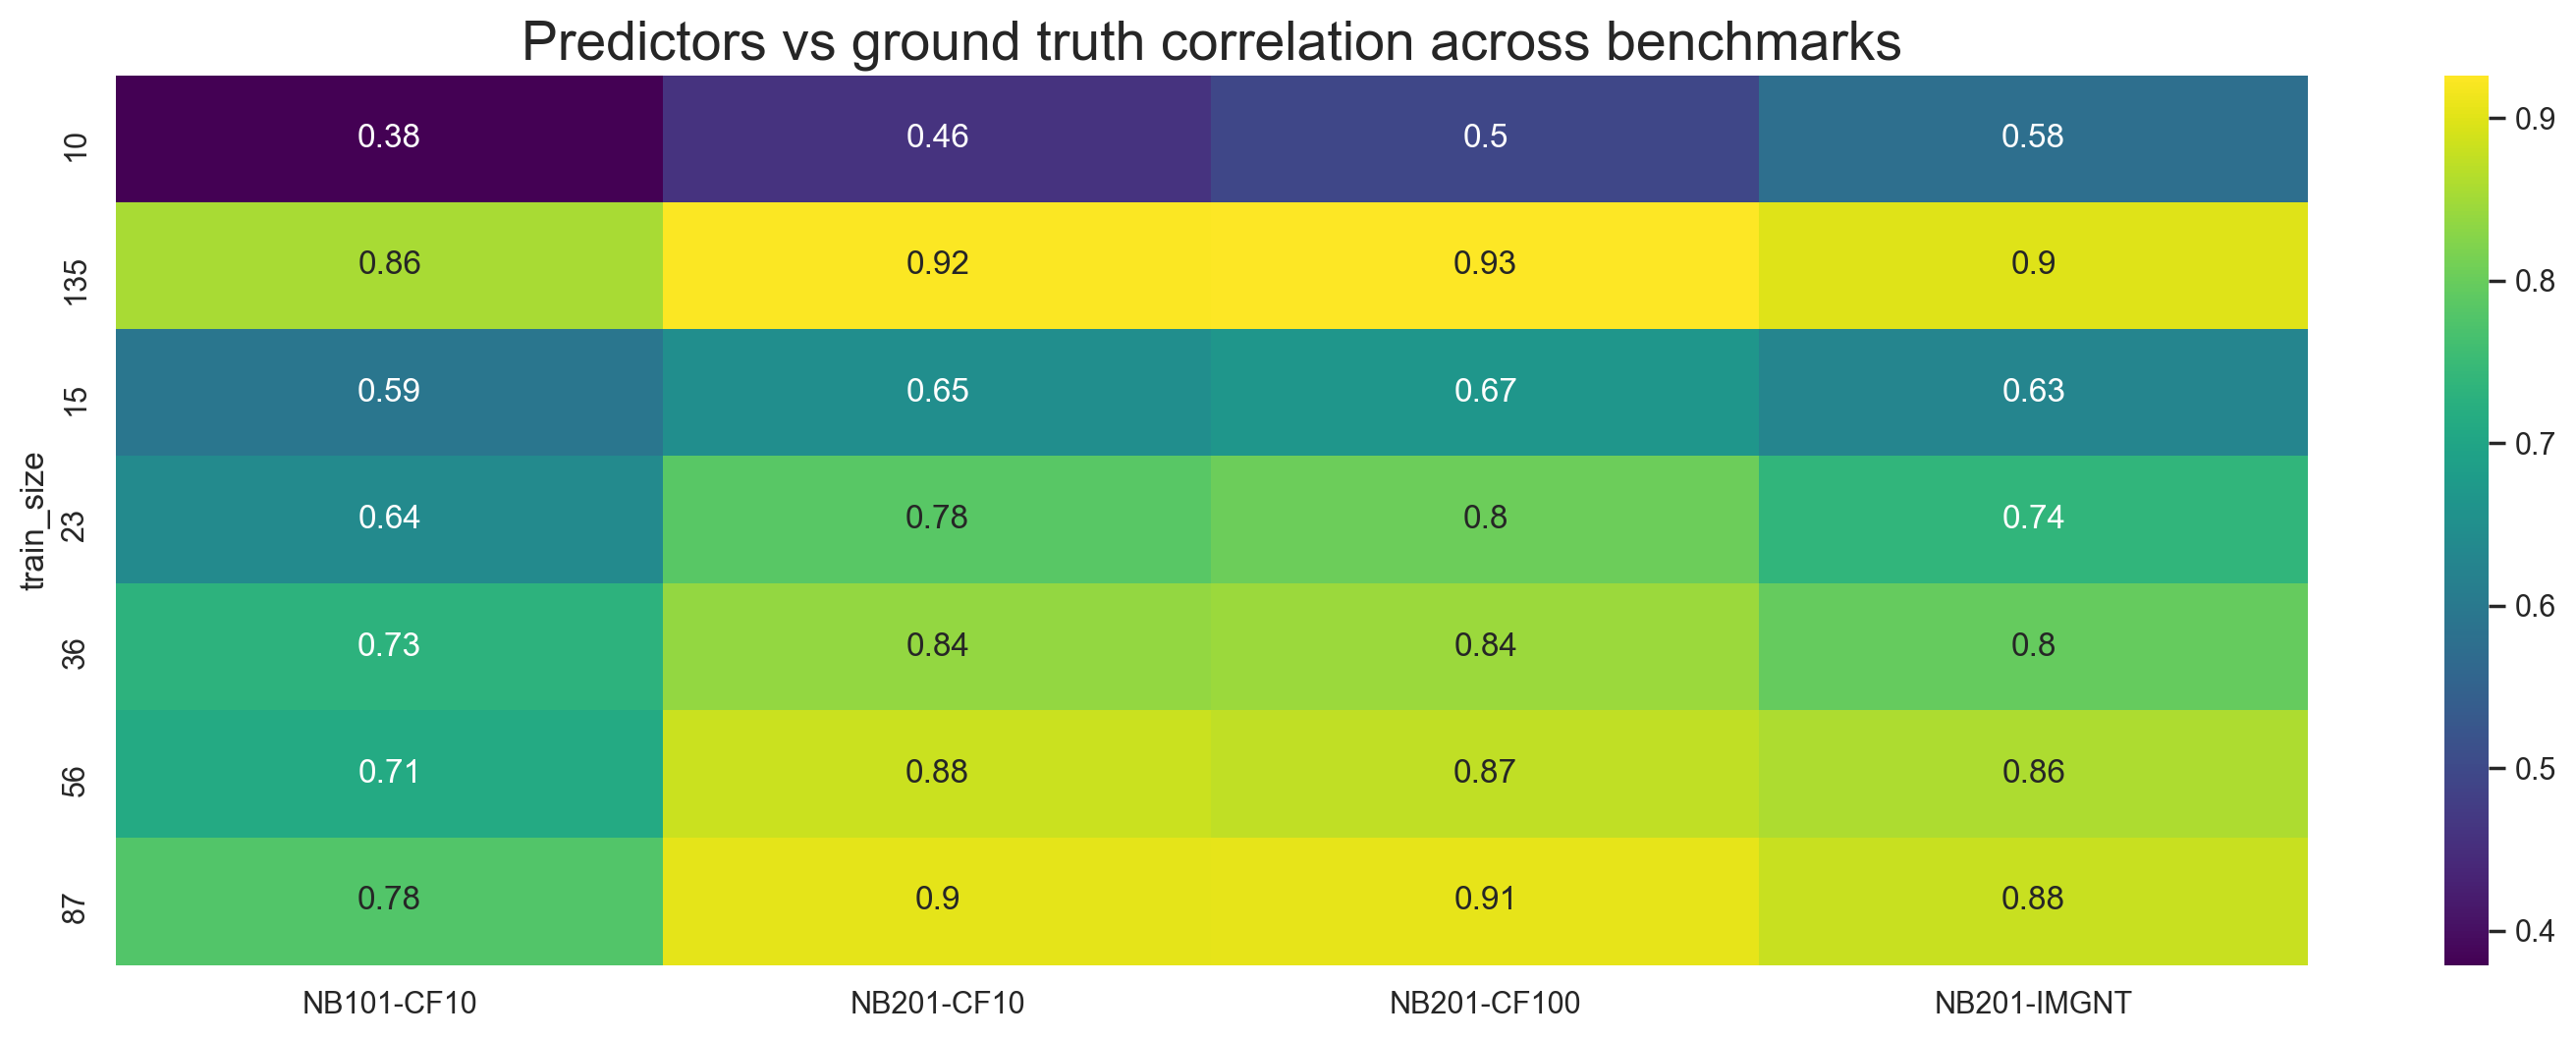

In [6]:
pred_df = make_search_space_train_size_df(df, 'spearman', BENCHMARKS)

plot_heatmap(pred_df, figsize=(18, 6), rotation=0, title='Predictors vs ground truth correlation across benchmarks')
# plot_heatmap(pred_df.corr(), figsize=(18, 6), rotation=0, title='Correlation between benchmarks')

# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar100', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'ImageNet16-120', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench301', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench101', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'transbench101_micro', 'jigsaw', 'spearman')
pred_df

In [7]:
def get_metrics(df, search_space, dataset, train_size, metric):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == str(train_size)) & (df['dataset'] == dataset)]
    return df_[metric].tolist()

def get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric):
    results = []

    for train_size in train_sizes:
        results.append(get_metrics(df, search_space, dataset, train_size, metric))

    results = np.array(results)
    means = np.mean(results, axis=1)
    stds = np.std(results, axis=1)
    
    return means, stds

def plot_line_chart(x_labels, means, stds, color, title='', ylabel=''):
    figsize=(16, 8)
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_labels, means, color=color)
    plt.fill_between(x_labels, means + stds, means - stds, color=color, alpha=0.2)
    plt.xscale('log', base=10)
    plt.xlabel('Train size')
    plt.ylabel(ylabel)

def plot_train_sizes_vs_metric(df, search_space, dataset, train_sizes, metric, color='gray'):
    means, stds = get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric)
    plot_line_chart(train_sizes, means, stds, color, title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient')


In [8]:
# train_sizes = [10, 16, 27, 46, 77, 129, 215, 359, 599]
train_sizes = [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]

# df = make_df(files)
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'kendalltau', color='green')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'kendalltau', color='blue')

In [9]:
def get_mean_grouped_by(df, search_space, dataset, train_size):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == train_size) & (df['dataset'] == dataset)]
    return df_.groupby(['search_space', 'dataset', 'train_size'], as_index=False).mean()

def get_averaged_df(df, search_space, train_sizes):
    dfs = []

    for dataset in BENCHMARKS[search_space]:
        for train_size in train_sizes:
            dfs.append(get_mean_grouped_by(df, search_space, dataset, str(train_size)))
    
    return pd.concat(dfs)

def get_feature_importance_df(df, search_space, train_size):
    avg_df = get_averaged_df(df, search_space, train_sizes)
    feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
    avg_df = avg_df[avg_df['train_size'] == train_size].set_index('dataset')[feat_imp_cols]
    return avg_df

def plot_feature_importance_heatmap(df, search_space, train_size):
    avg_df = get_feature_importance_df(df, search_space, str(train_size))
    plot_heatmap(avg_df, rotation=45, title=f'{search_space}. Train size: {train_size}')

In [10]:
avg_df = get_averaged_df(df, 'nasbench201', train_sizes)
avg_df

,search_space,dataset,train_size,kendalltau,pearson,spearman,flops_feat_imp,params_feat_imp,snip_feat_imp,jacov_feat_imp,grad_norm_feat_imp,plain_feat_imp,epe_nas_feat_imp,fisher_feat_imp,grasp_feat_imp,l2_norm_feat_imp,synflow_feat_imp
0,nasbench201,cifar10,10,0.322052,0.340914,0.459546,5.60,0.0,0.20,2.4,2.4,5.60,15.6,11.40,4.00,12.40,0.8
0,nasbench201,cifar10,15,0.471462,0.521429,0.647734,9.40,0.0,0.40,12.4,2.2,6.60,32.4,11.40,2.00,10.40,5.0
0,nasbench201,cifar10,23,0.590106,0.683800,0.783709,20.00,0.0,2.20,18.2,1.8,10.20,38.6,23.80,3.80,10.40,17.8
0,nasbench201,cifar10,36,0.652534,0.695368,0.838379,30.20,0.0,1.40,22.2,3.8,15.60,55.4,12.80,11.40,16.80,36.8
0,nasbench201,cifar10,56,0.706579,0.765133,0.882496,20.60,1.2,8.80,36.6,12.8,21.40,63.2,29.00,20.40,30.20,47.2
0,nasbench201,cifar10,87,0.733710,0.812333,0.903663,38.00,1.8,13.80,58.2,18.8,38.20,61.8,44.80,27.80,33.40,52.2
0,nasbench201,cifar10,135,0.769248,0.856663,0.924112,43.40,0.2,24.60,84.8,32.6,65.60,78.4,62.00,48.40,48.80,64.8
0,nasbench201,cifar10,209,0.782427,0.937726,0.932042,58.25,0.0,36.75,115.5,60.0,94.25,138.0,86.75,89.75,69.75,99.5
0,nasbench201,cifar10,323,0.796035,0.911262,0.940441,95.20,0.6,63.40,157.4,96.0,140.80,165.2,131.00,119.60,105.60,141.0
0,nasbench201,cifar100,10,0.350927,0.422873,0.496342,8.40,0.0,0.00,9.2,3.2,1.60,10.0,8.80,0.80,3.40,5.2


In [11]:
feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
feat_imp_cols

['flops_feat_imp',
 'params_feat_imp',
 'snip_feat_imp',
 'jacov_feat_imp',
 'grad_norm_feat_imp',
 'plain_feat_imp',
 'epe_nas_feat_imp',
 'fisher_feat_imp',
 'grasp_feat_imp',
 'l2_norm_feat_imp',
 'synflow_feat_imp']

In [12]:
df = make_df(files)

ValueError: zero-size array to reduction operation fmin which has no identity

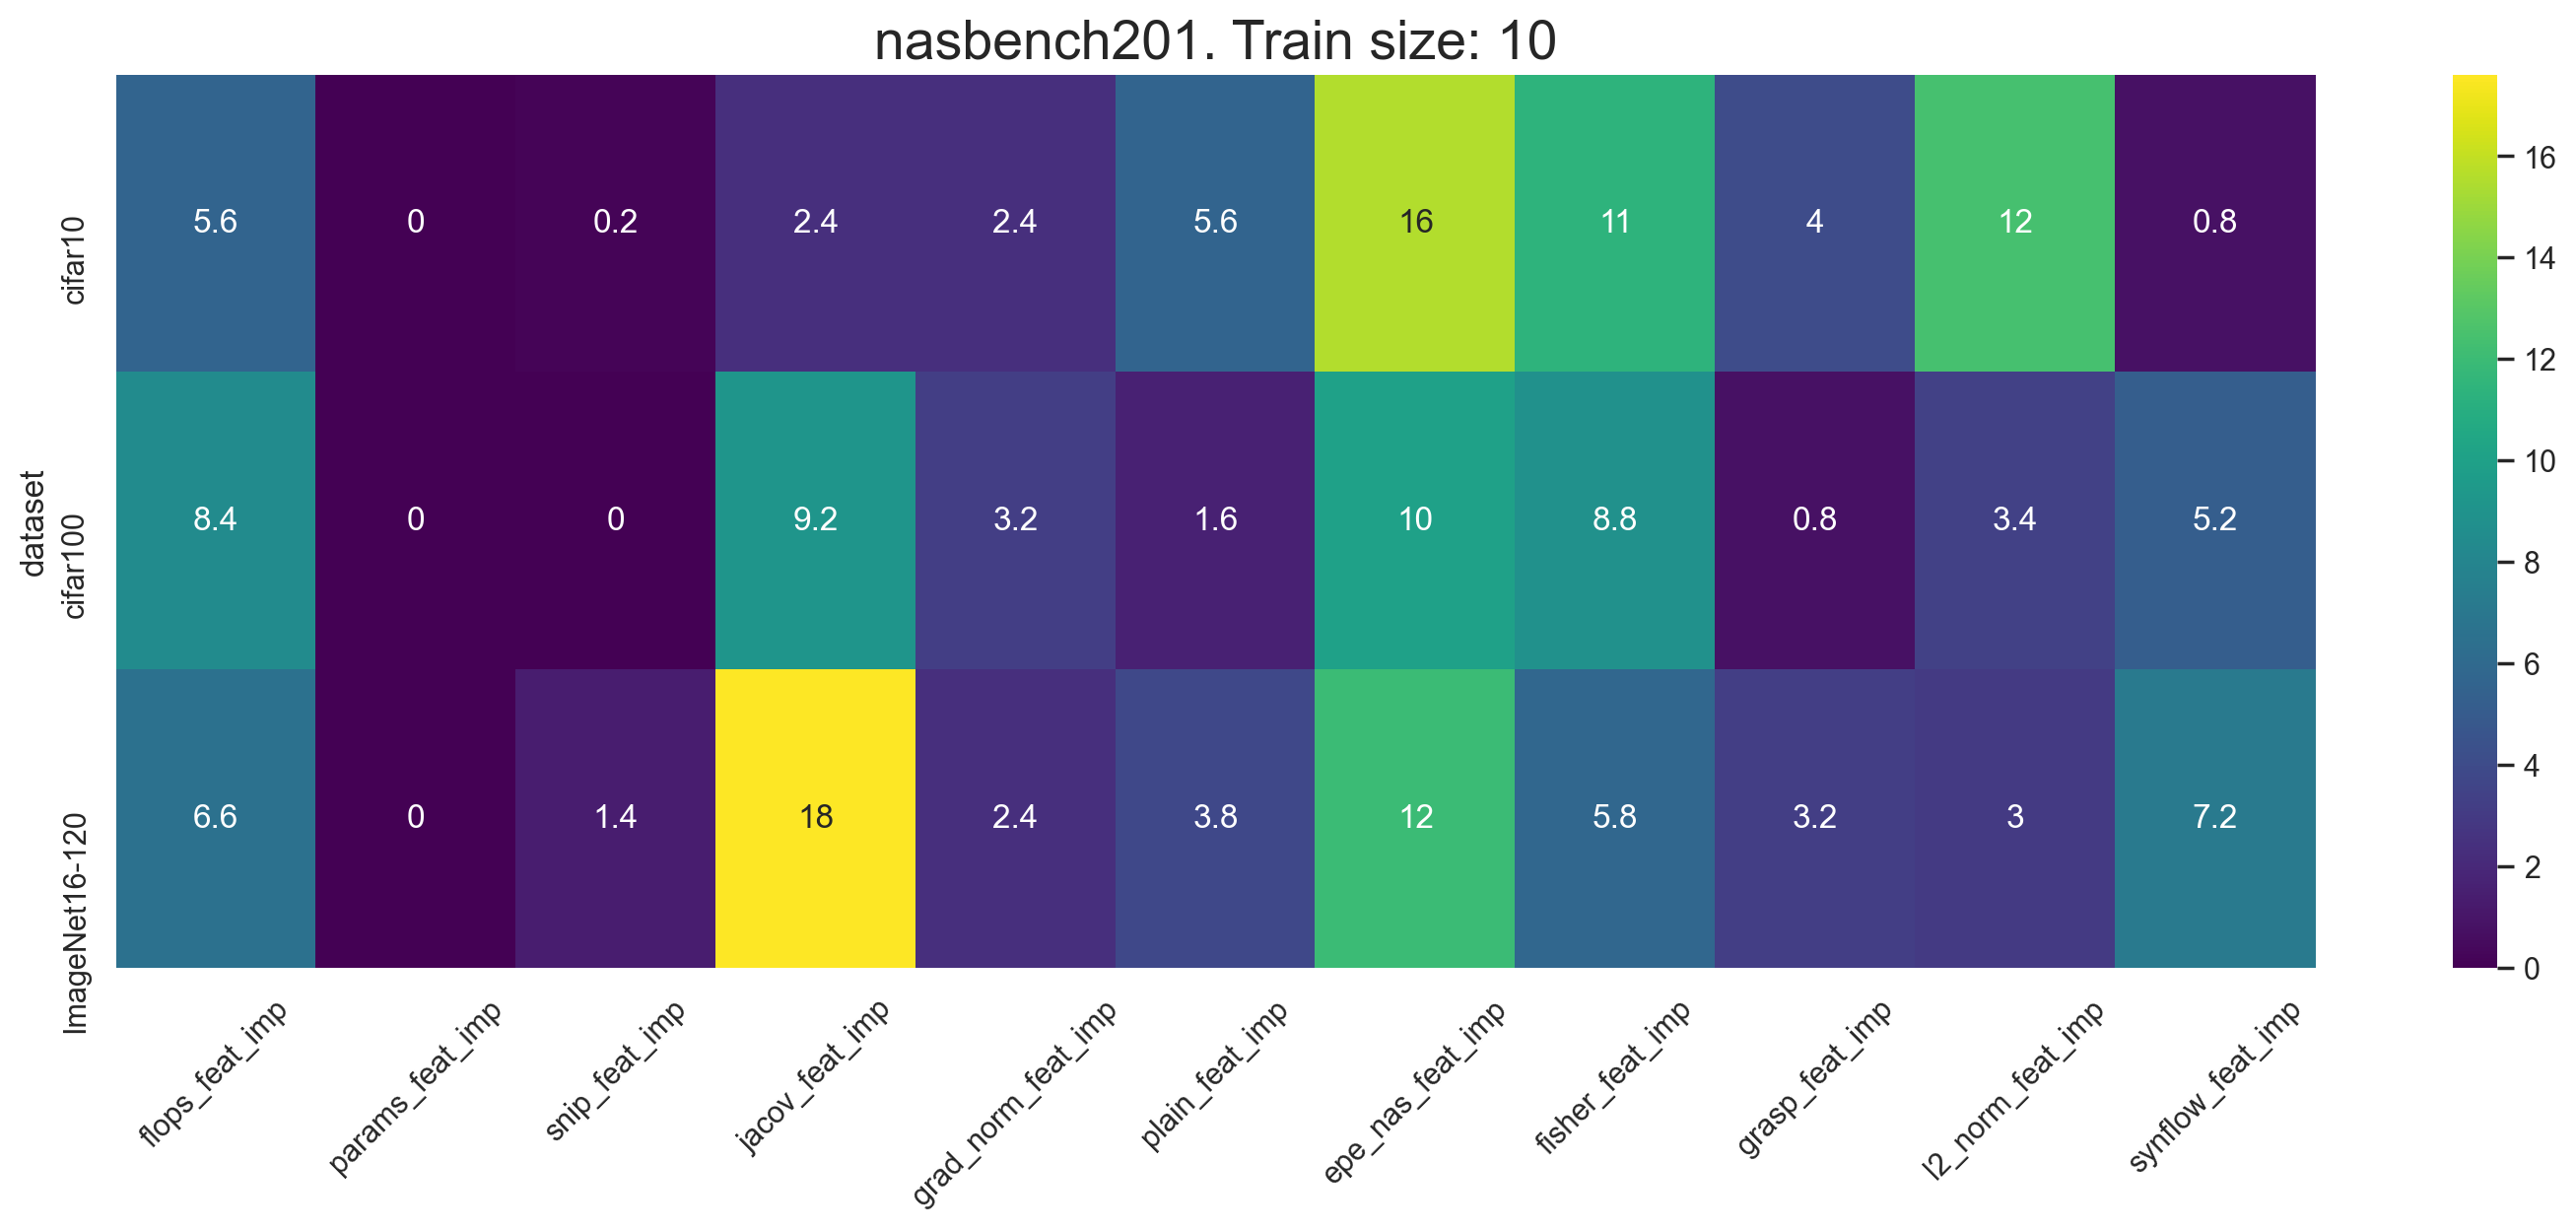

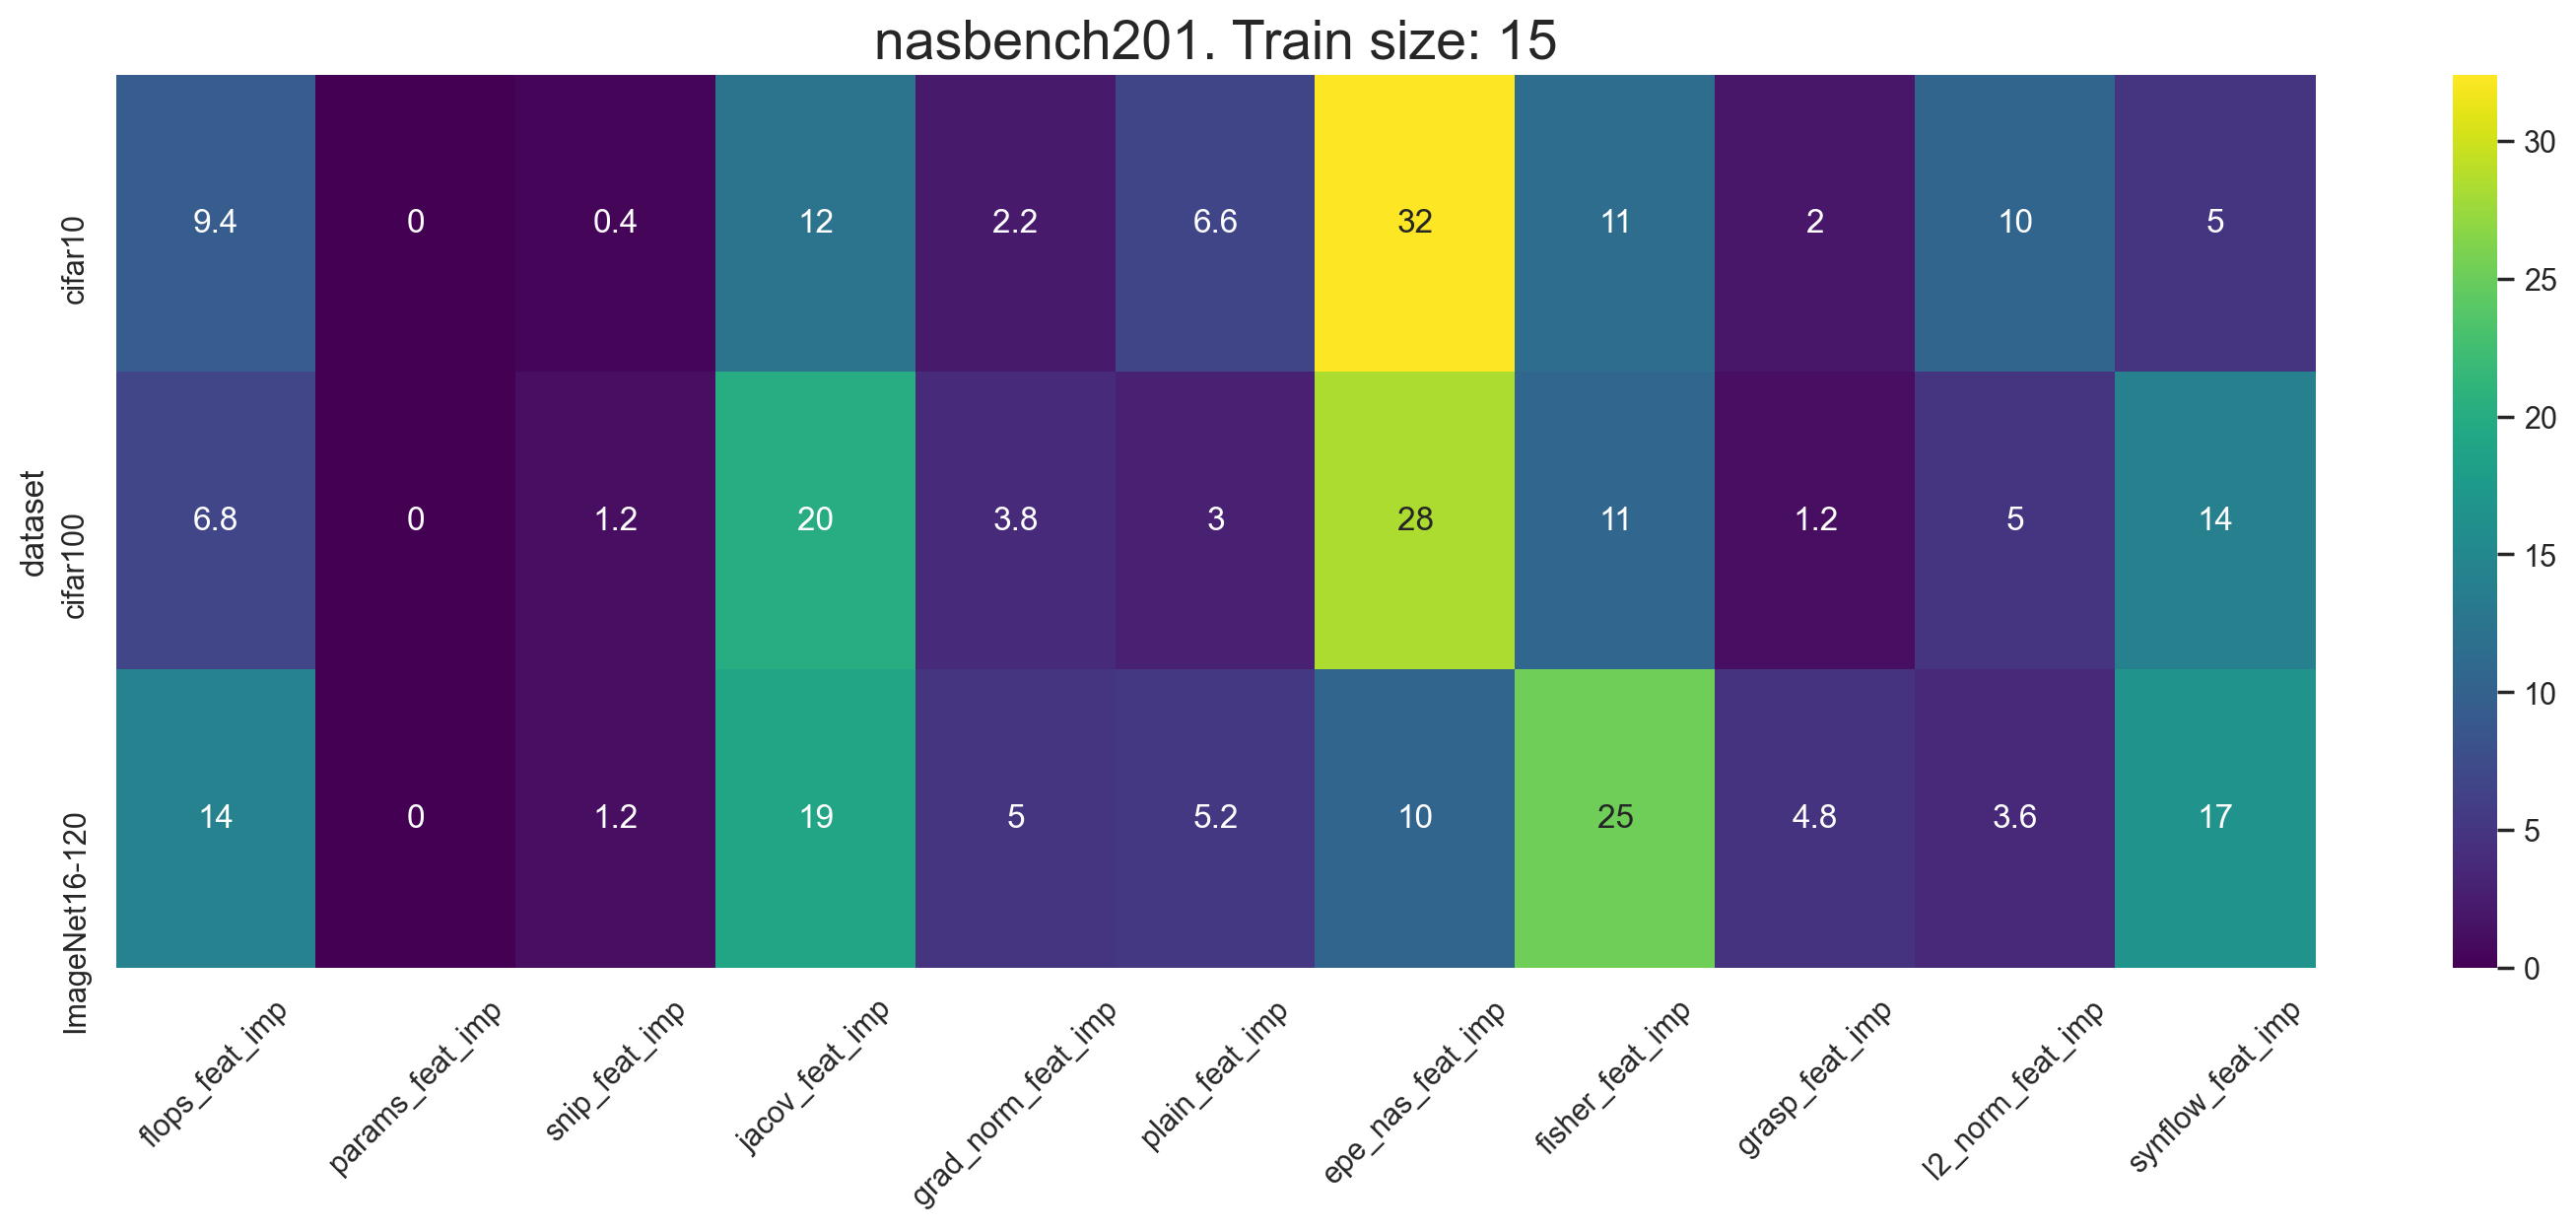

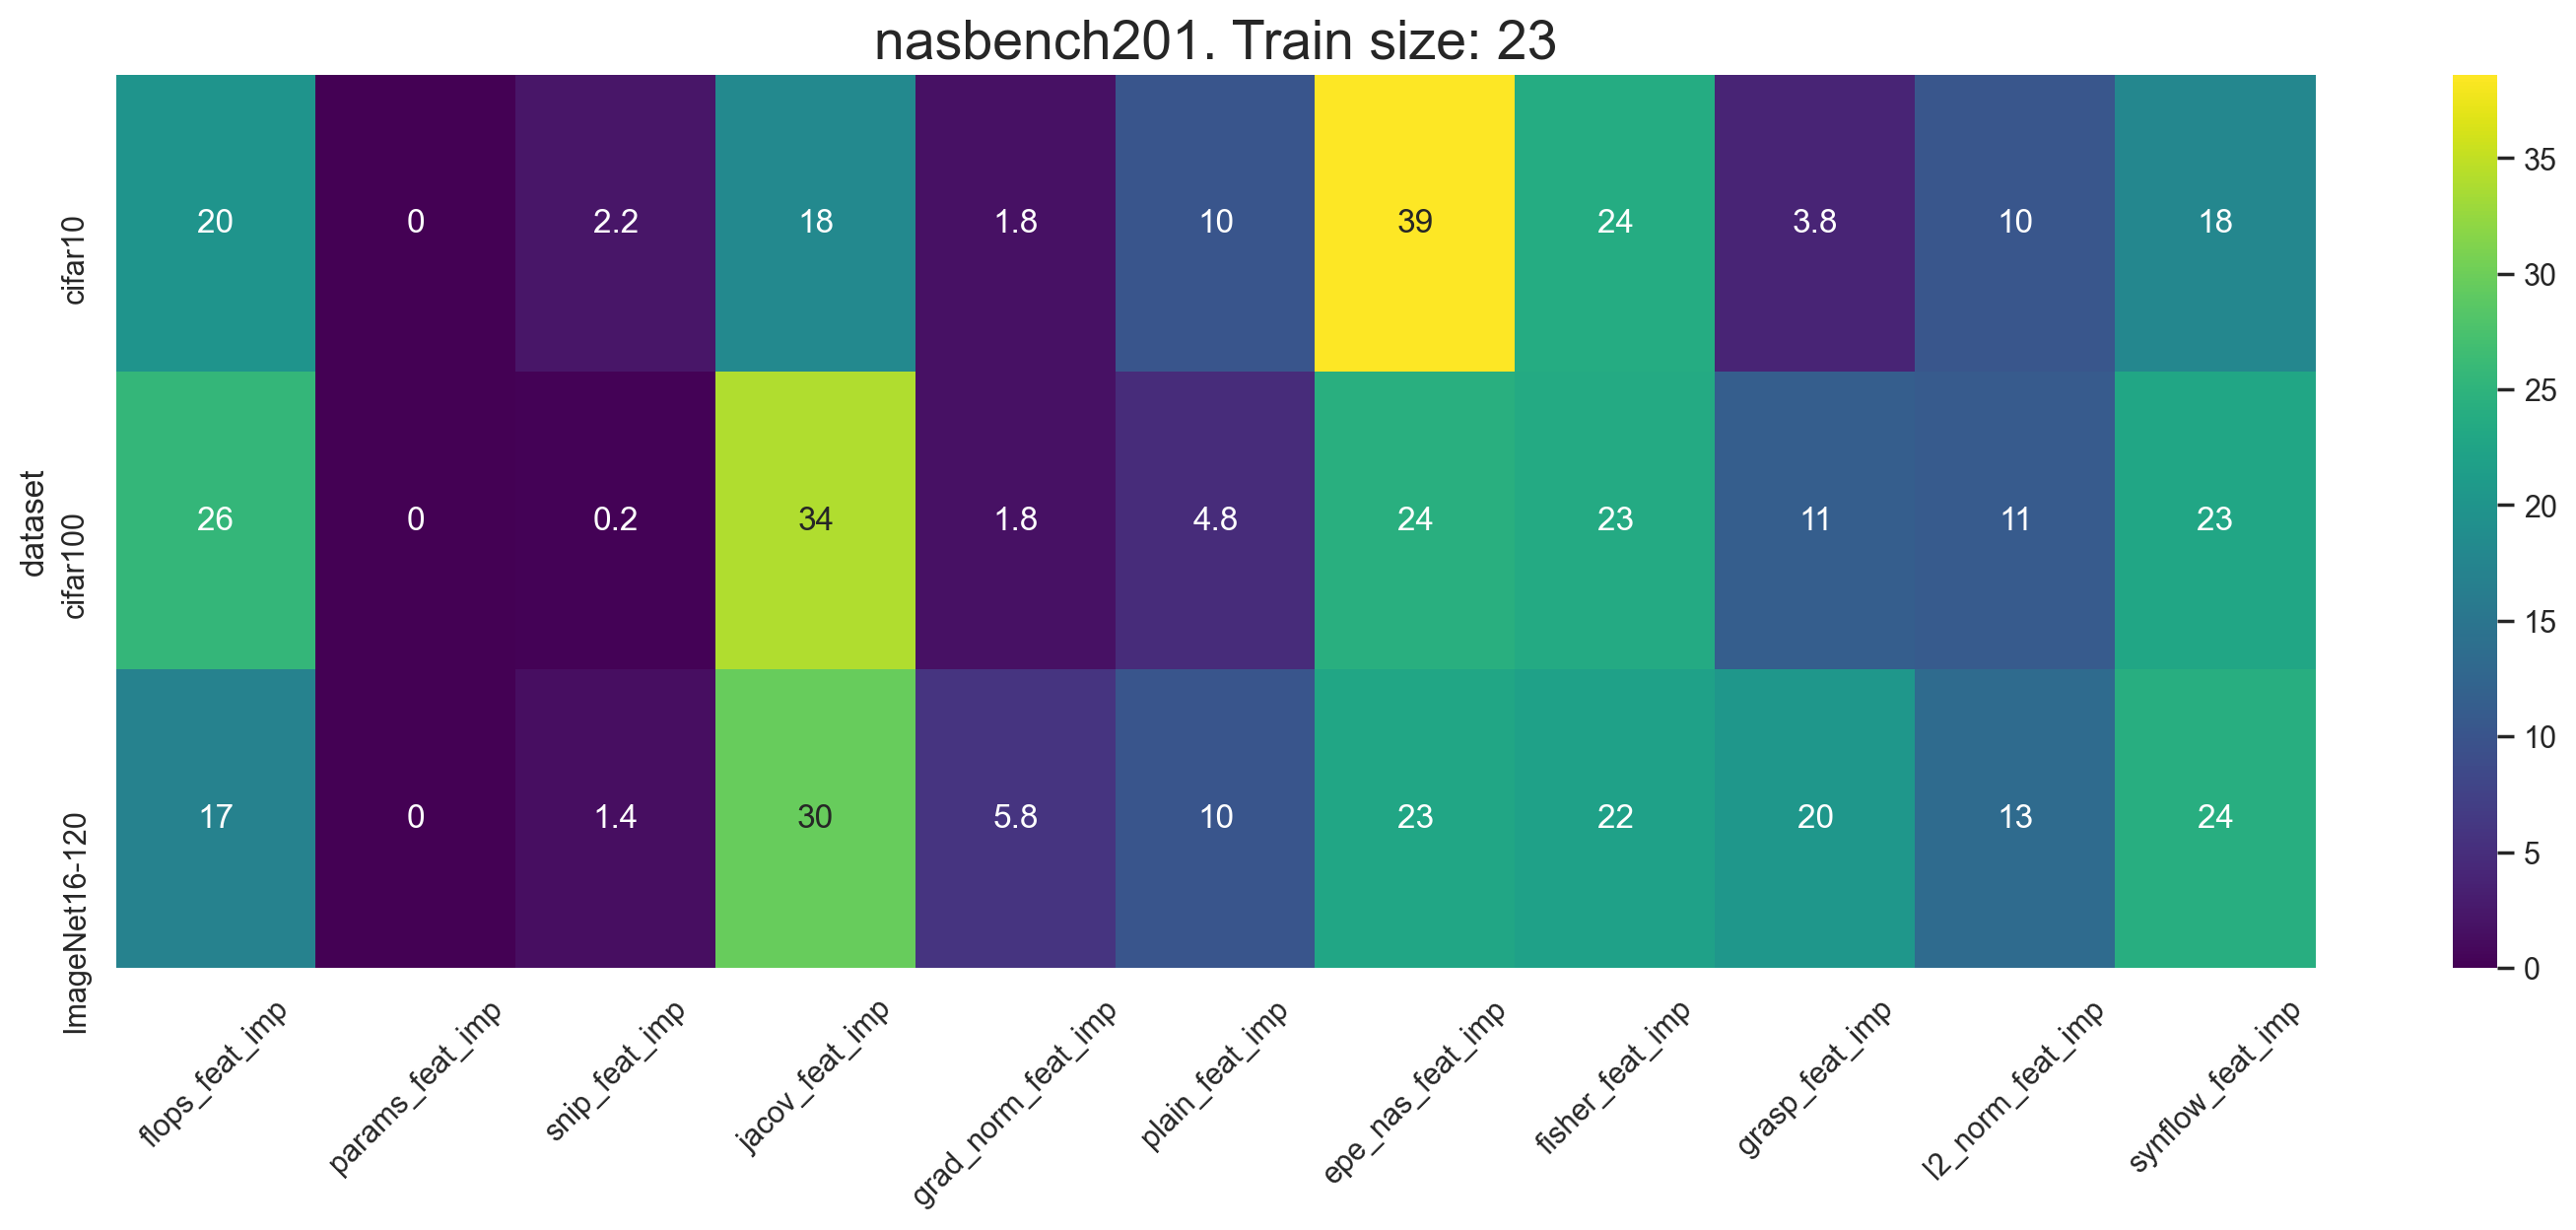

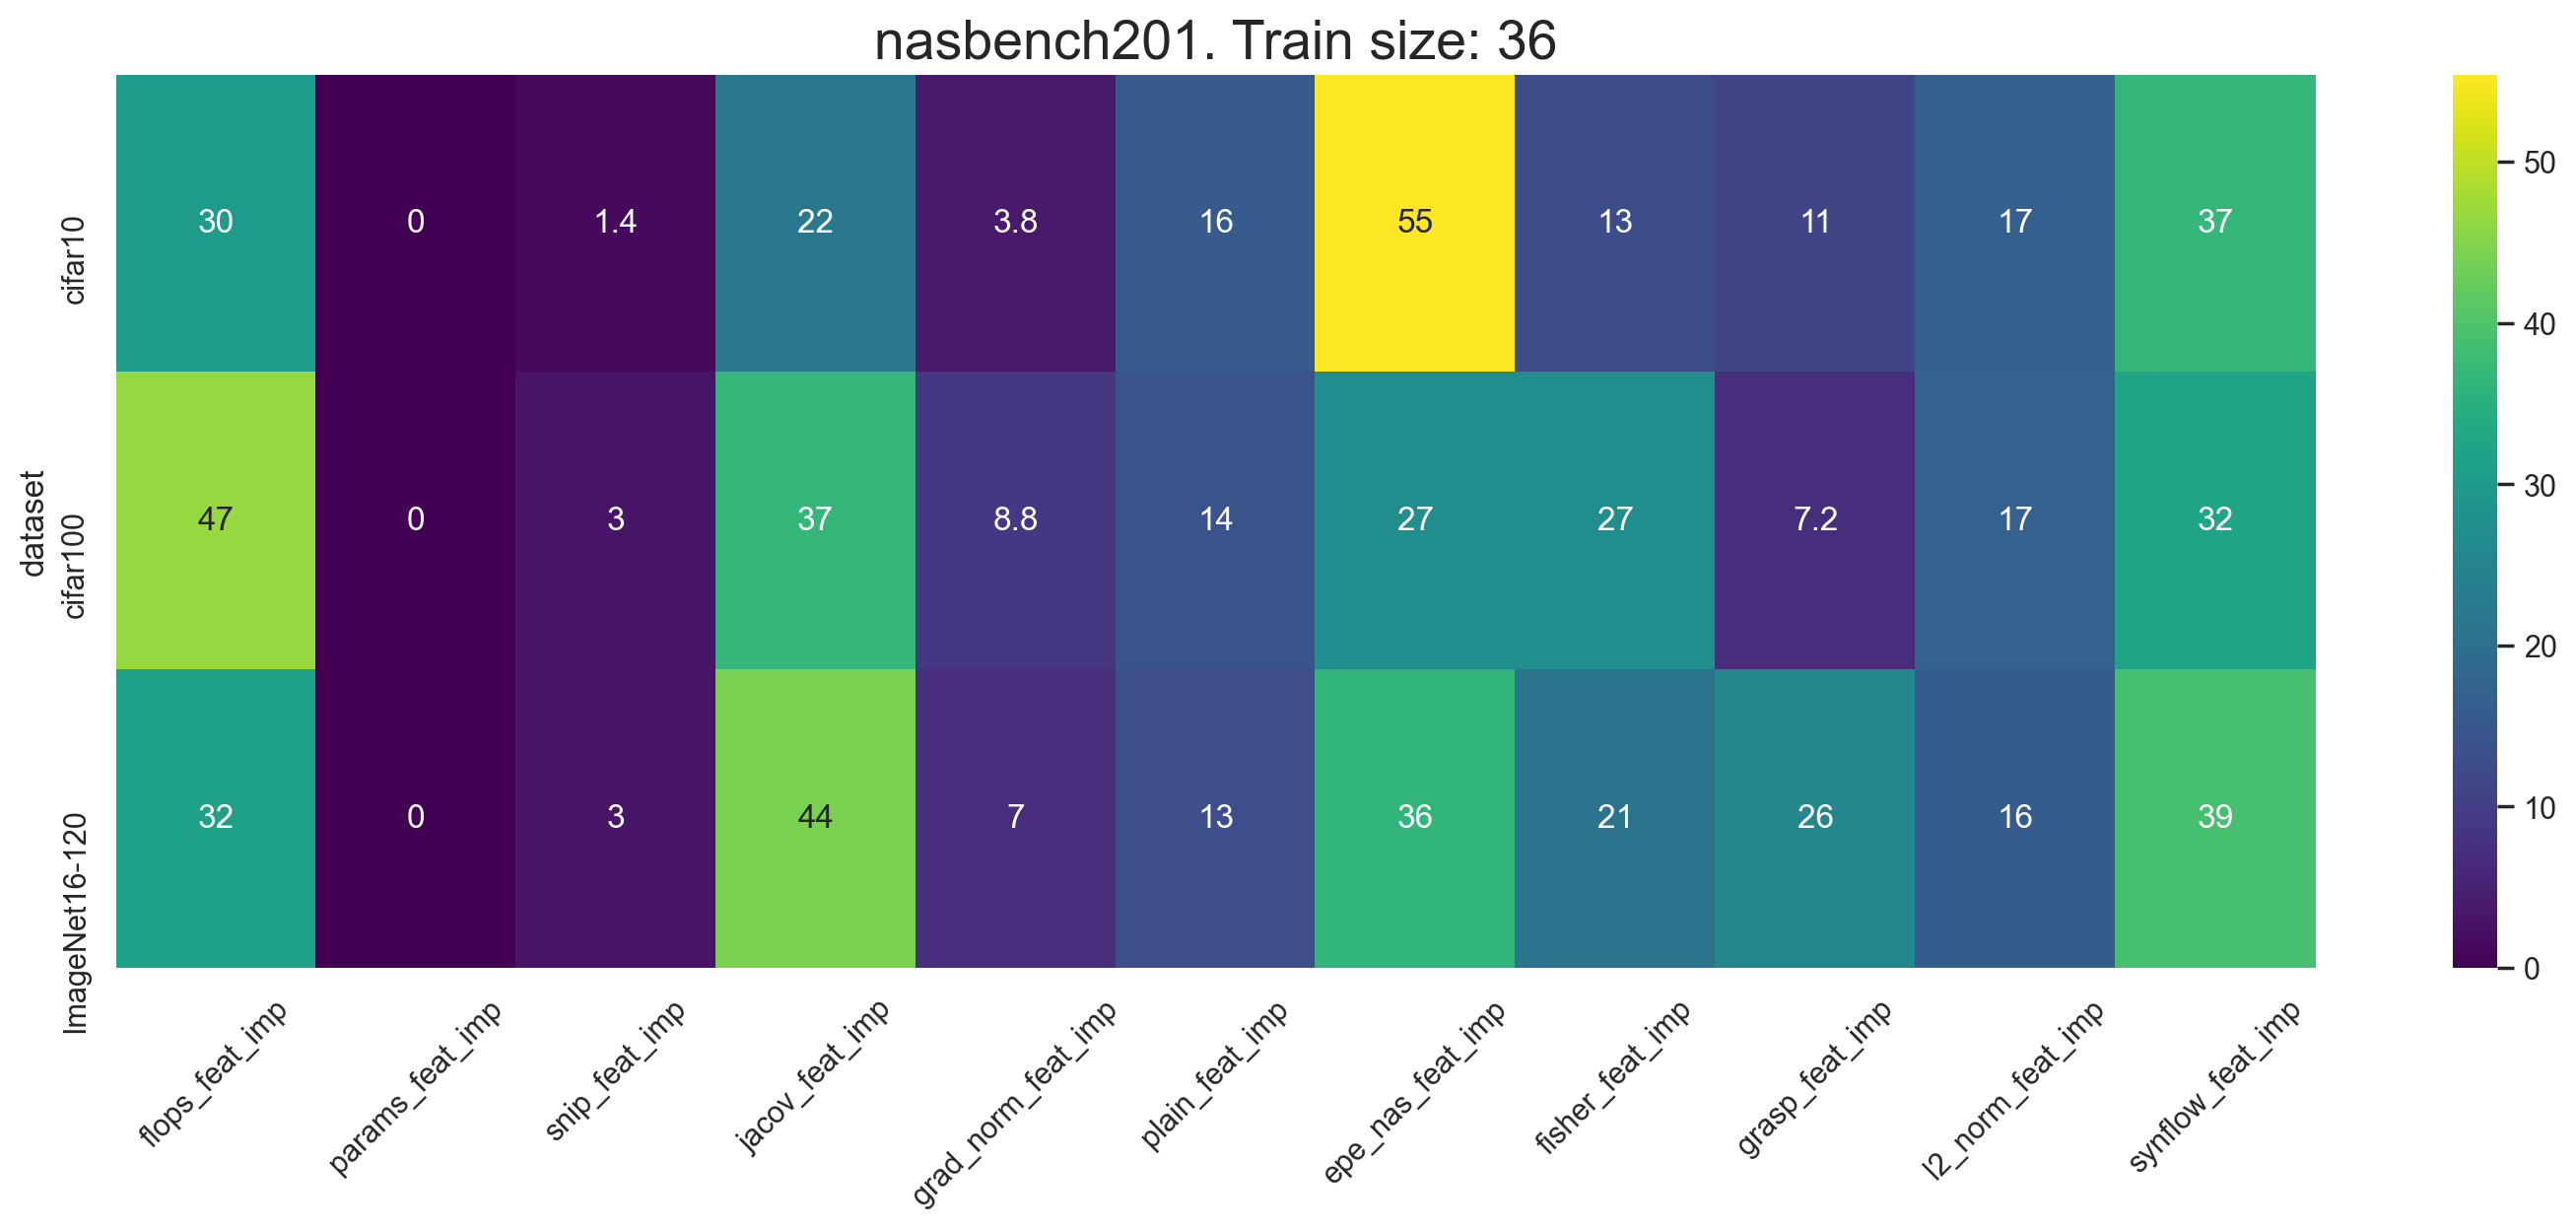

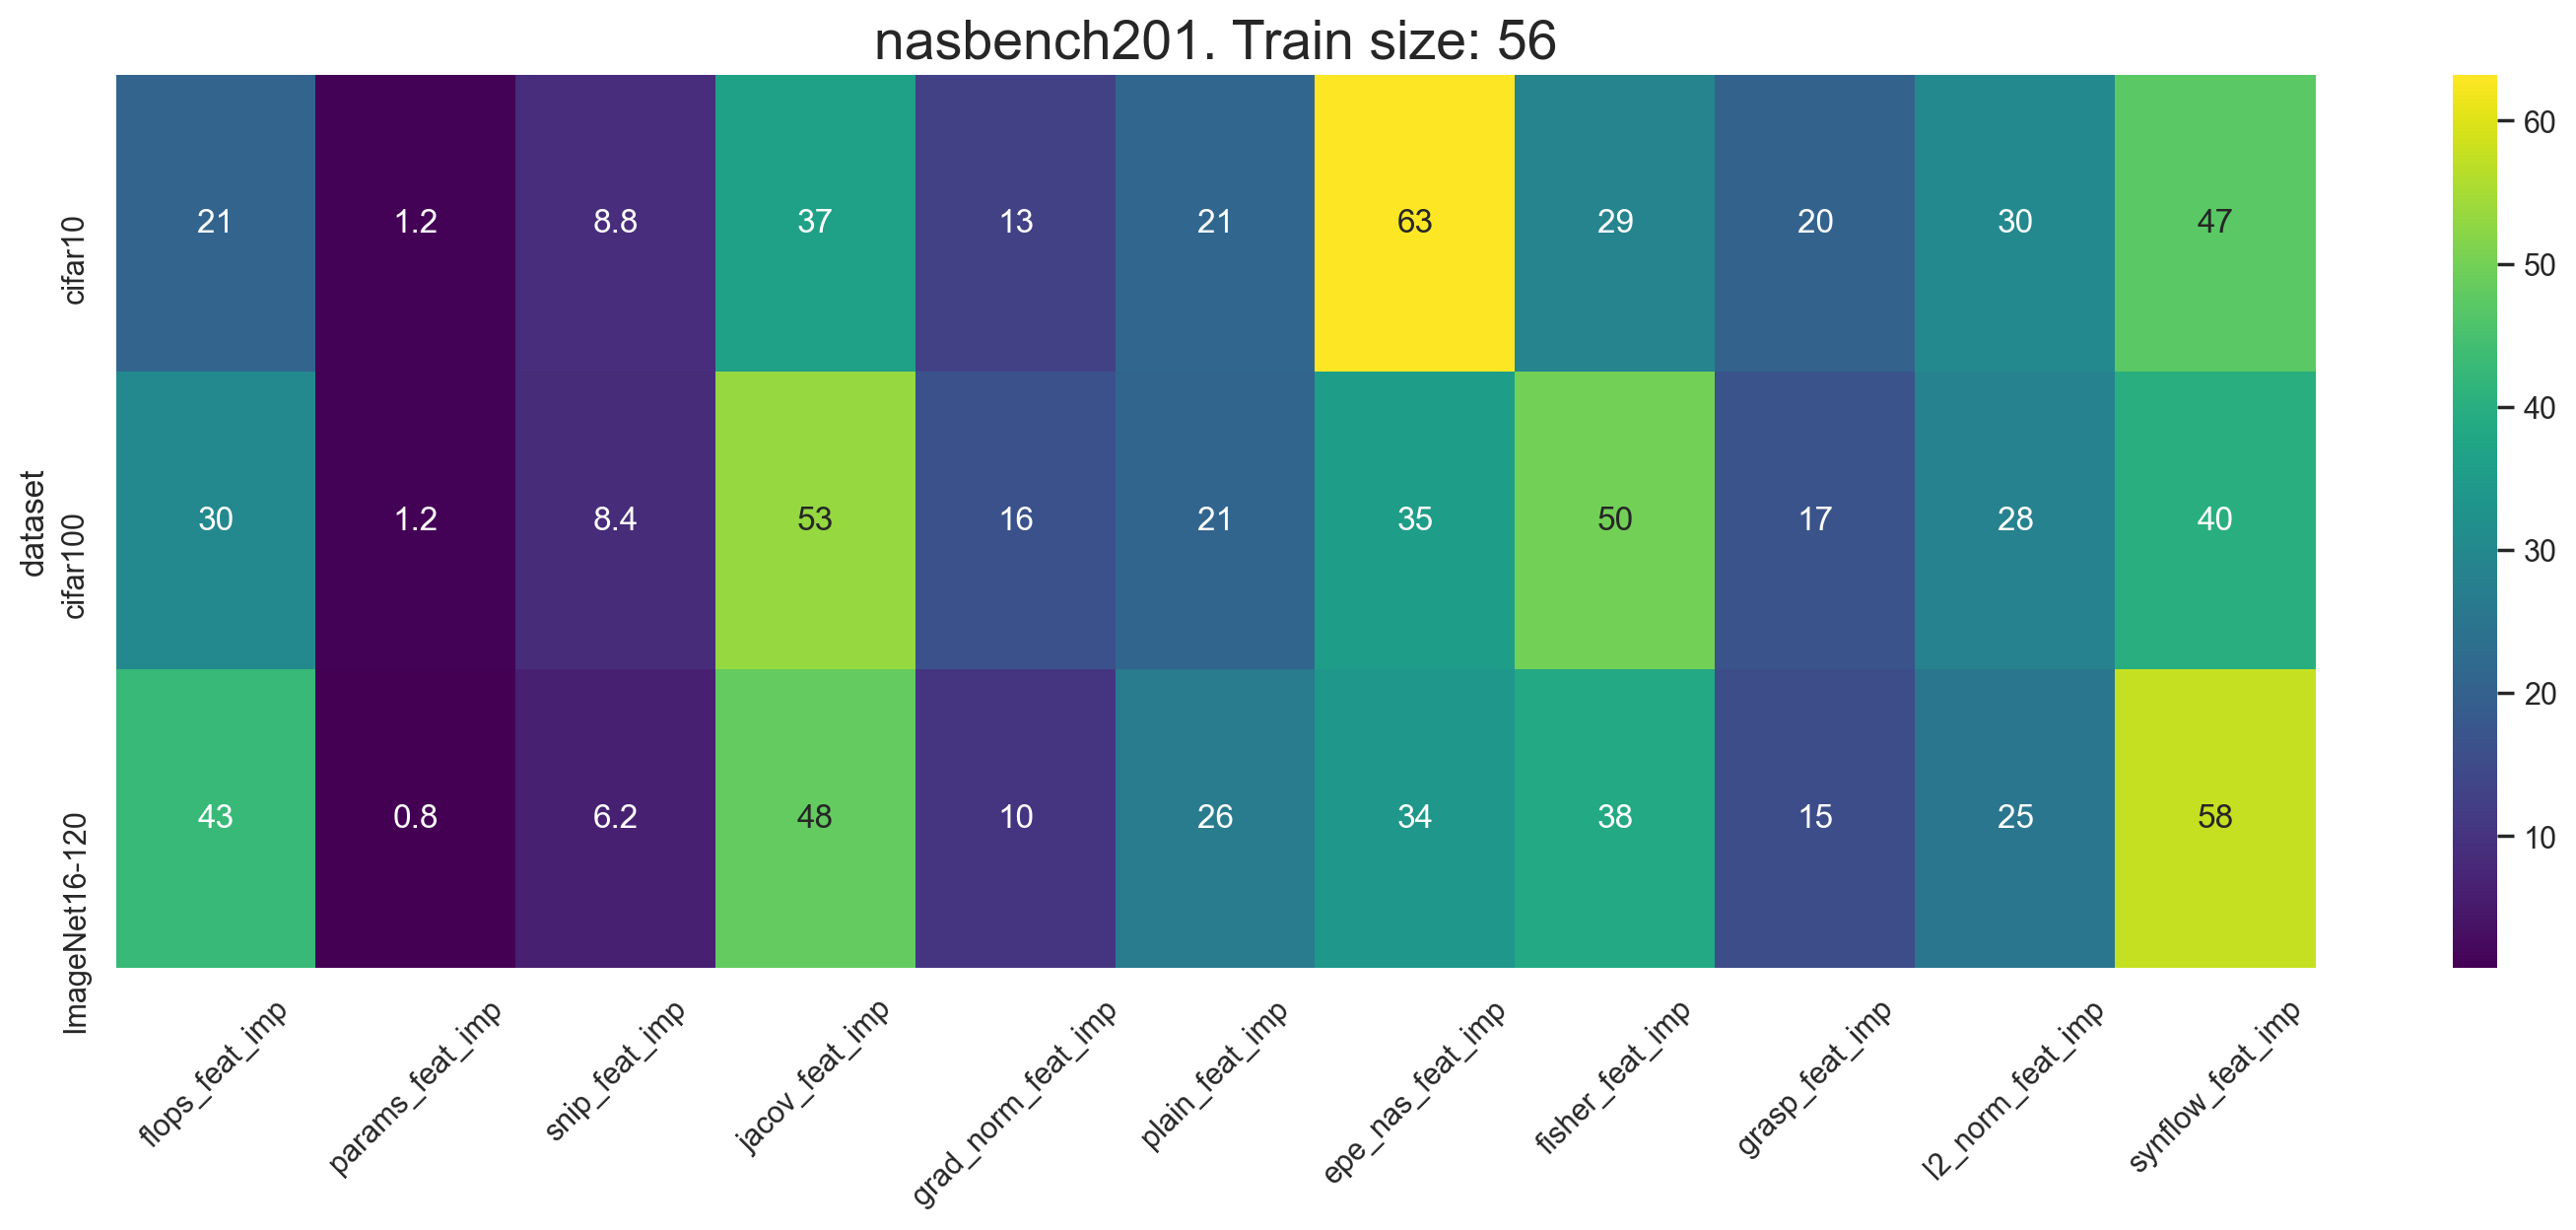

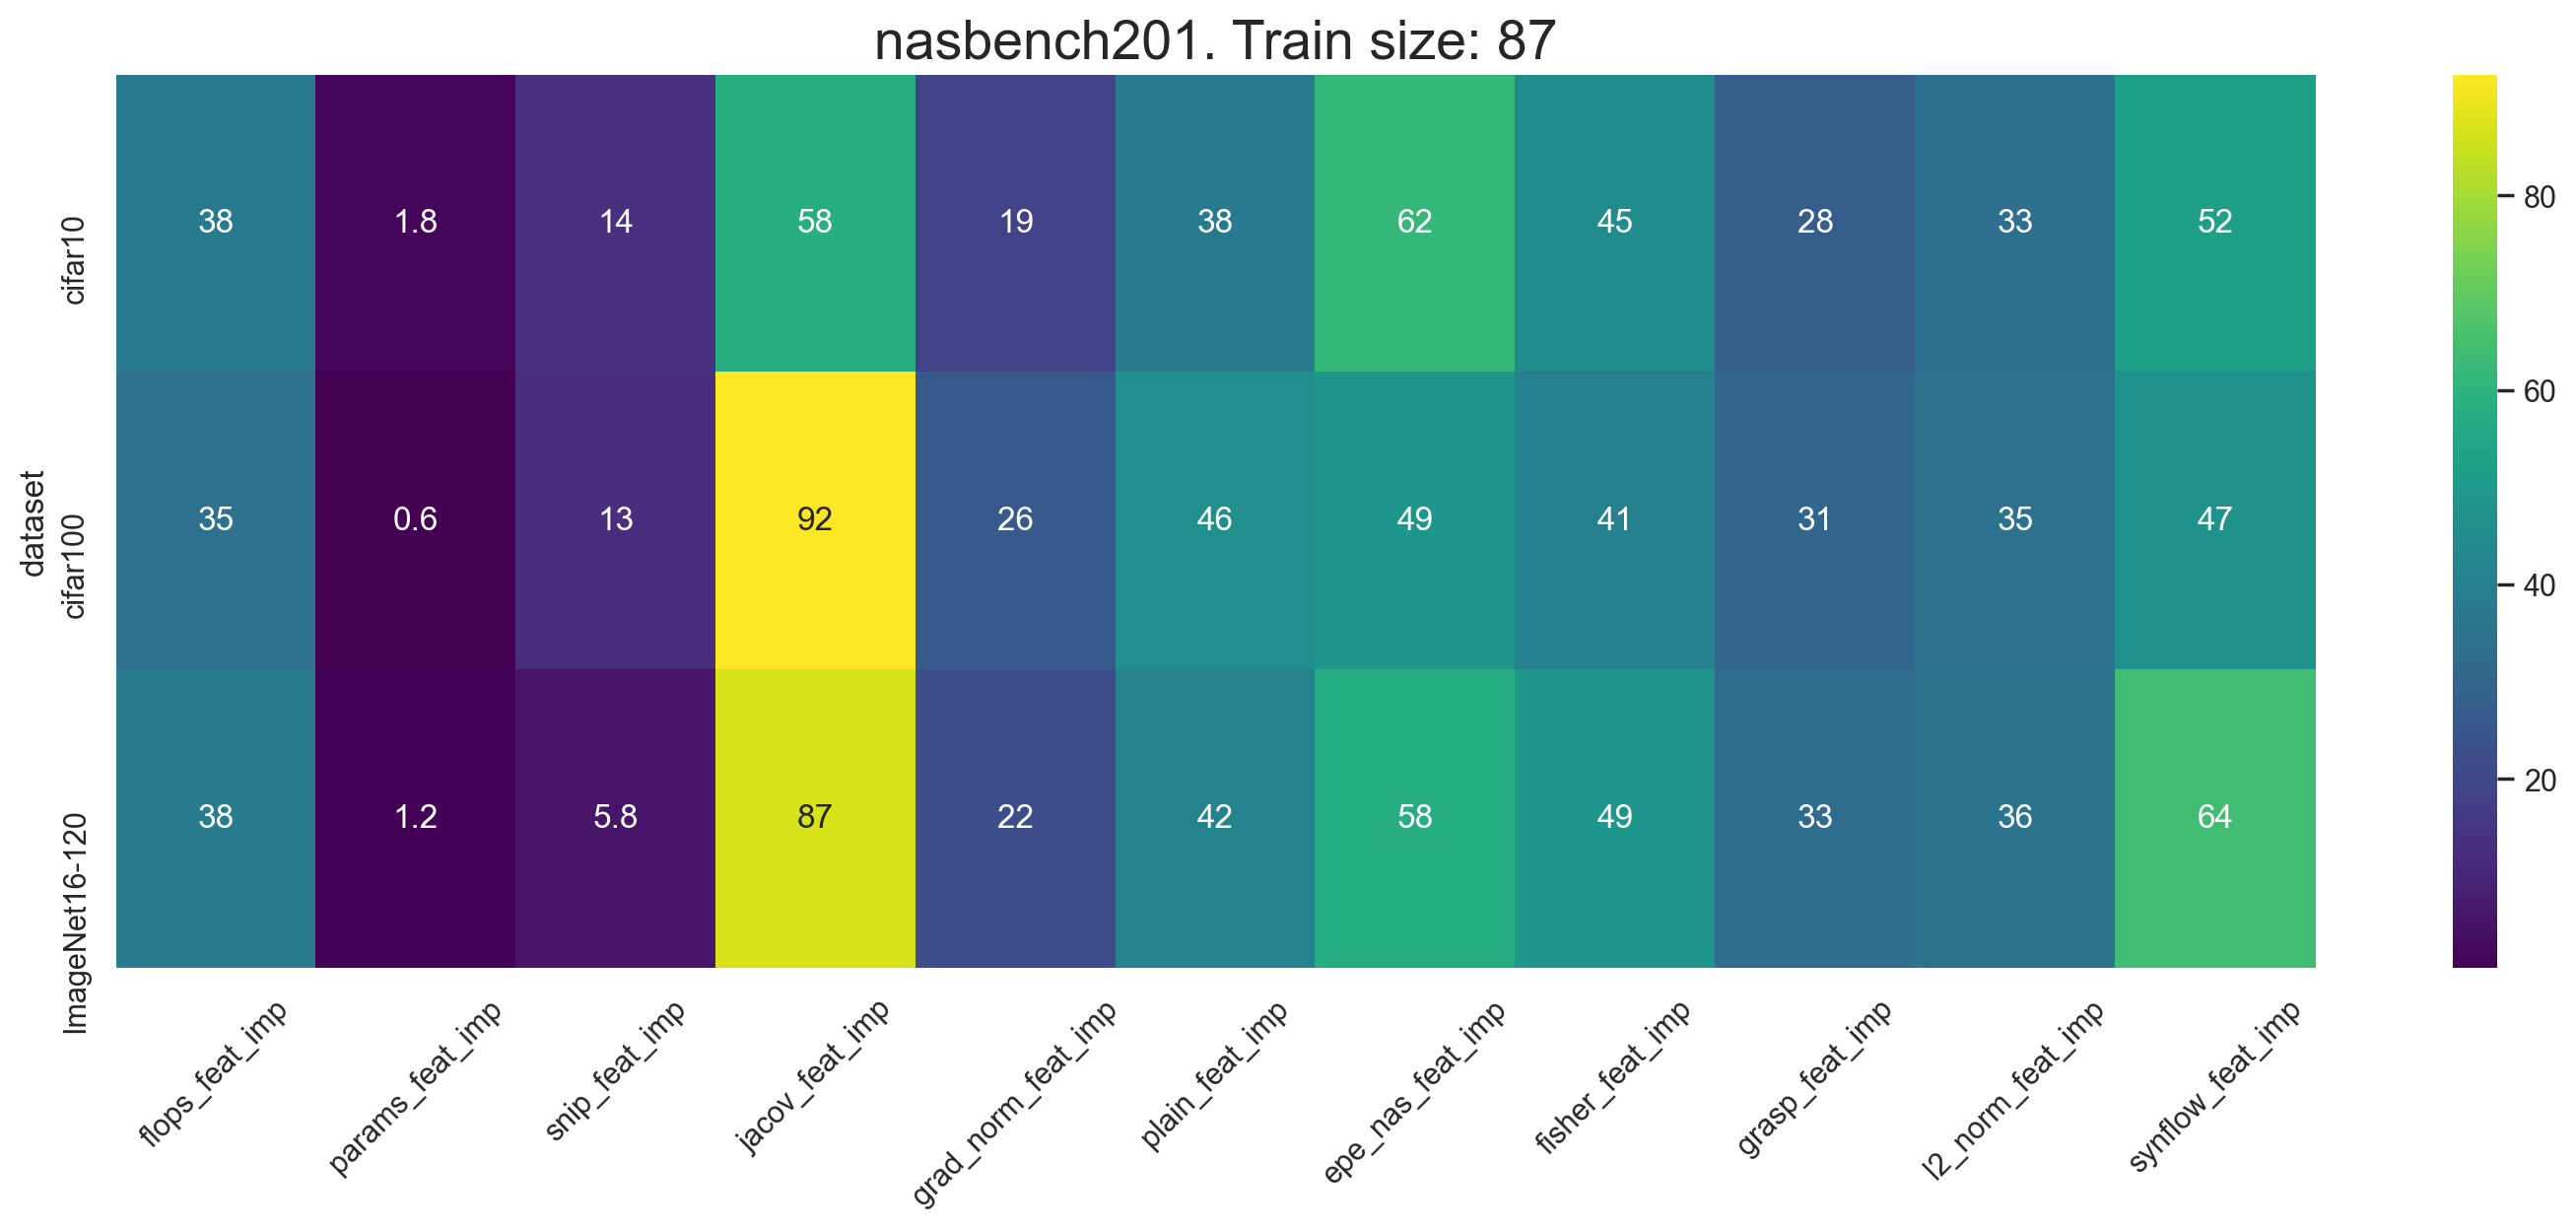

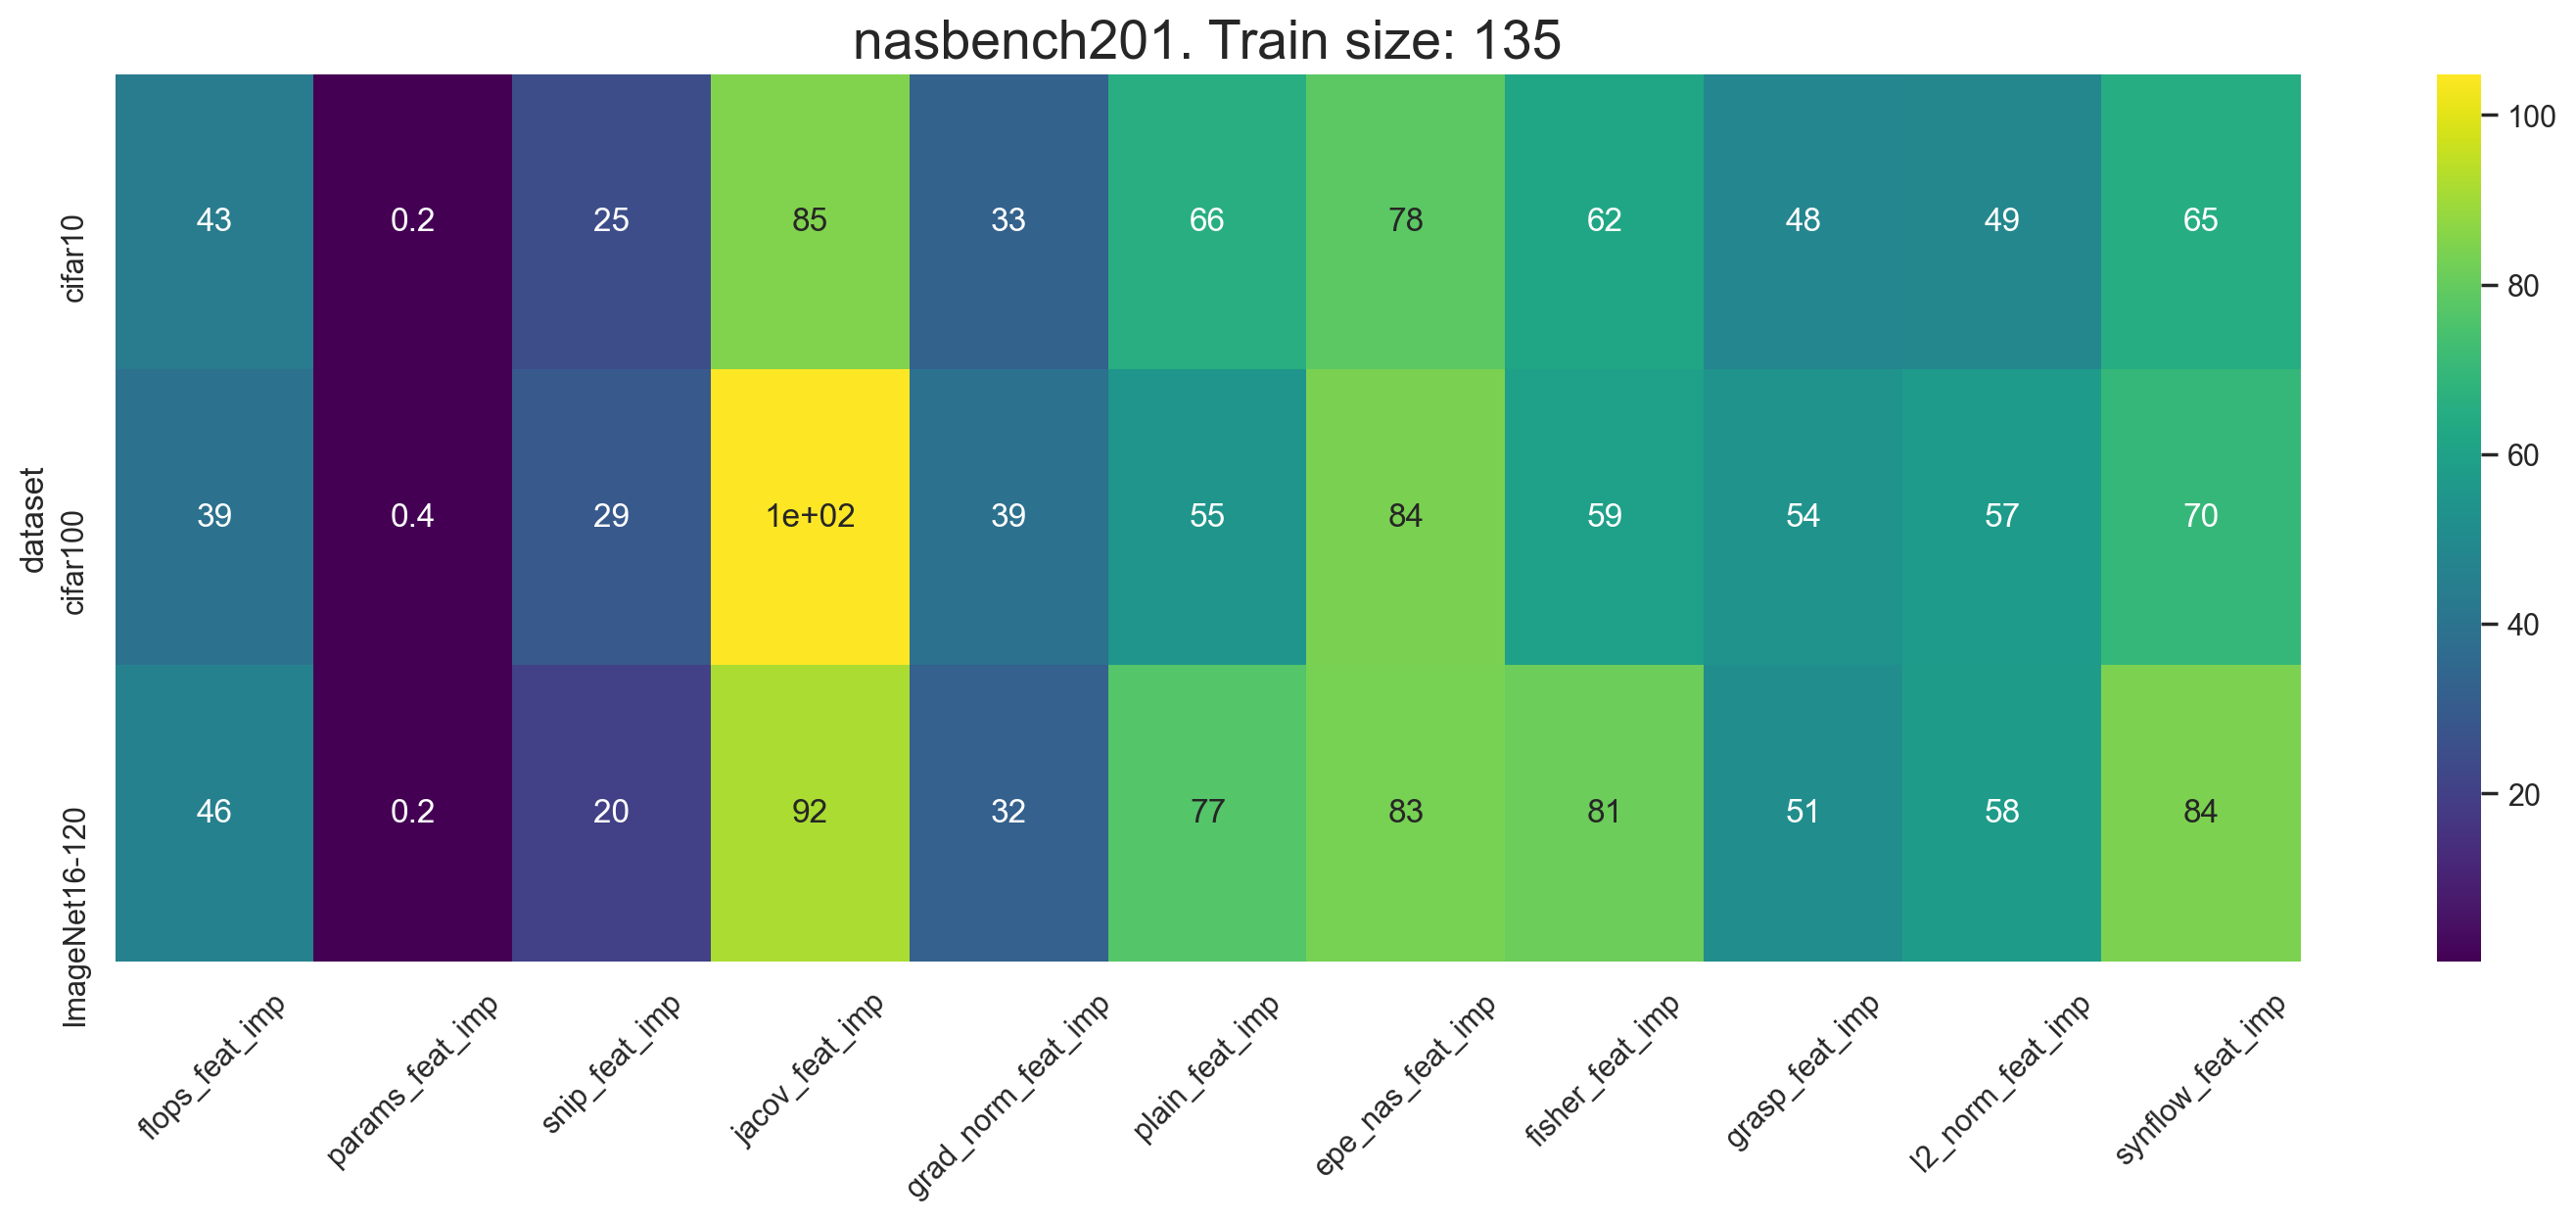

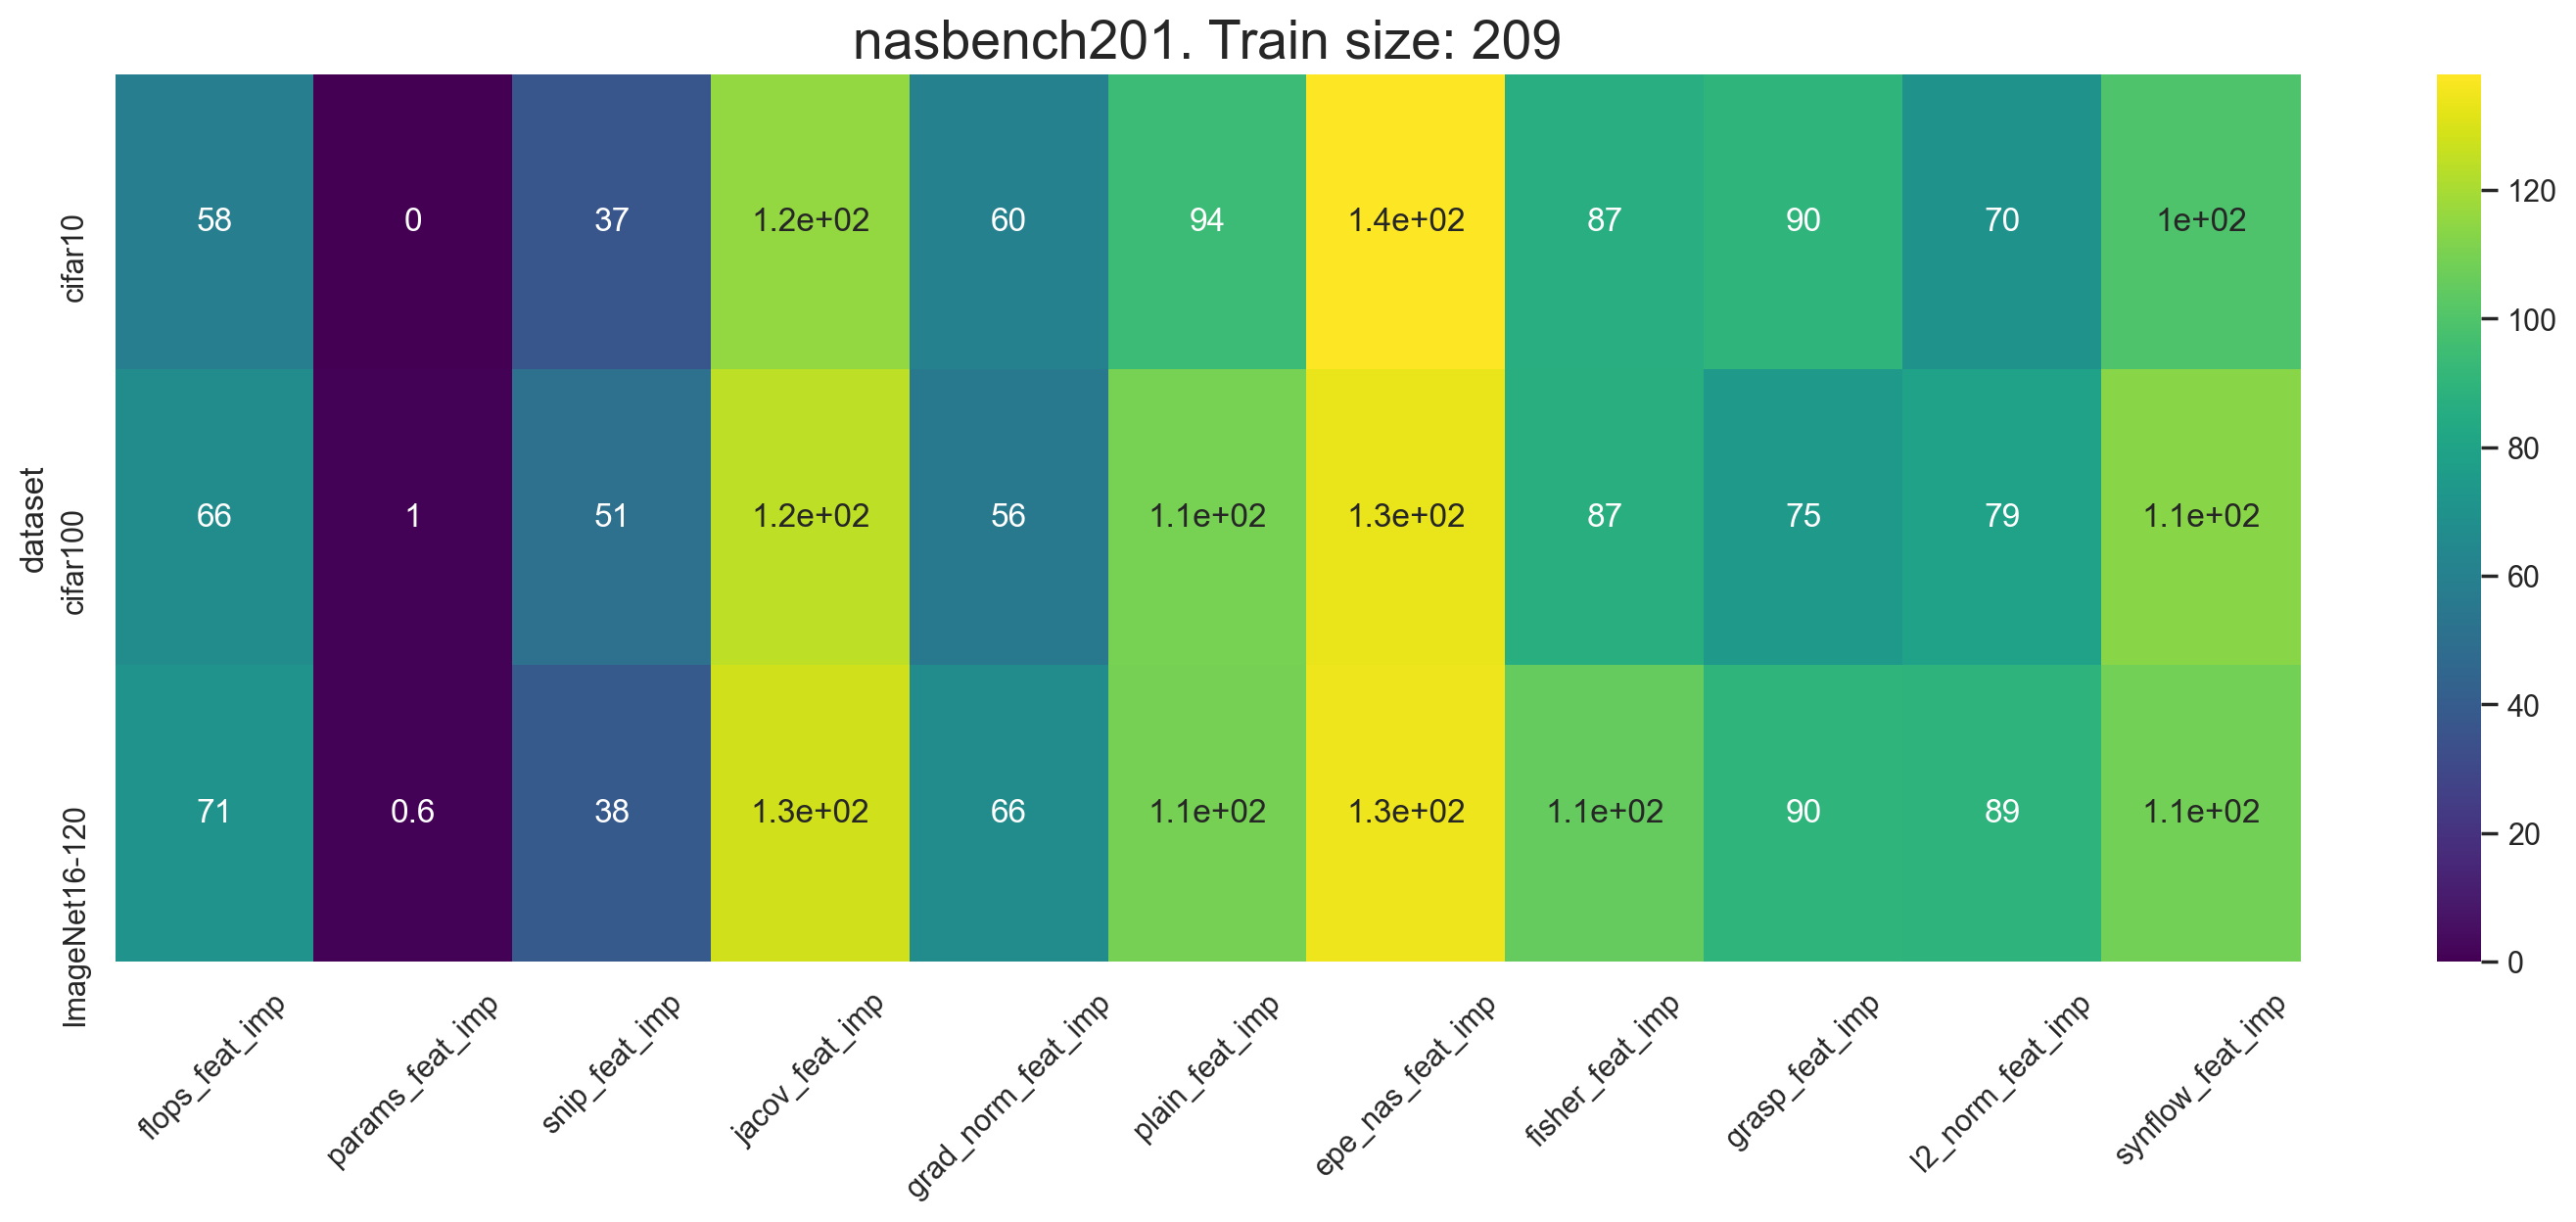

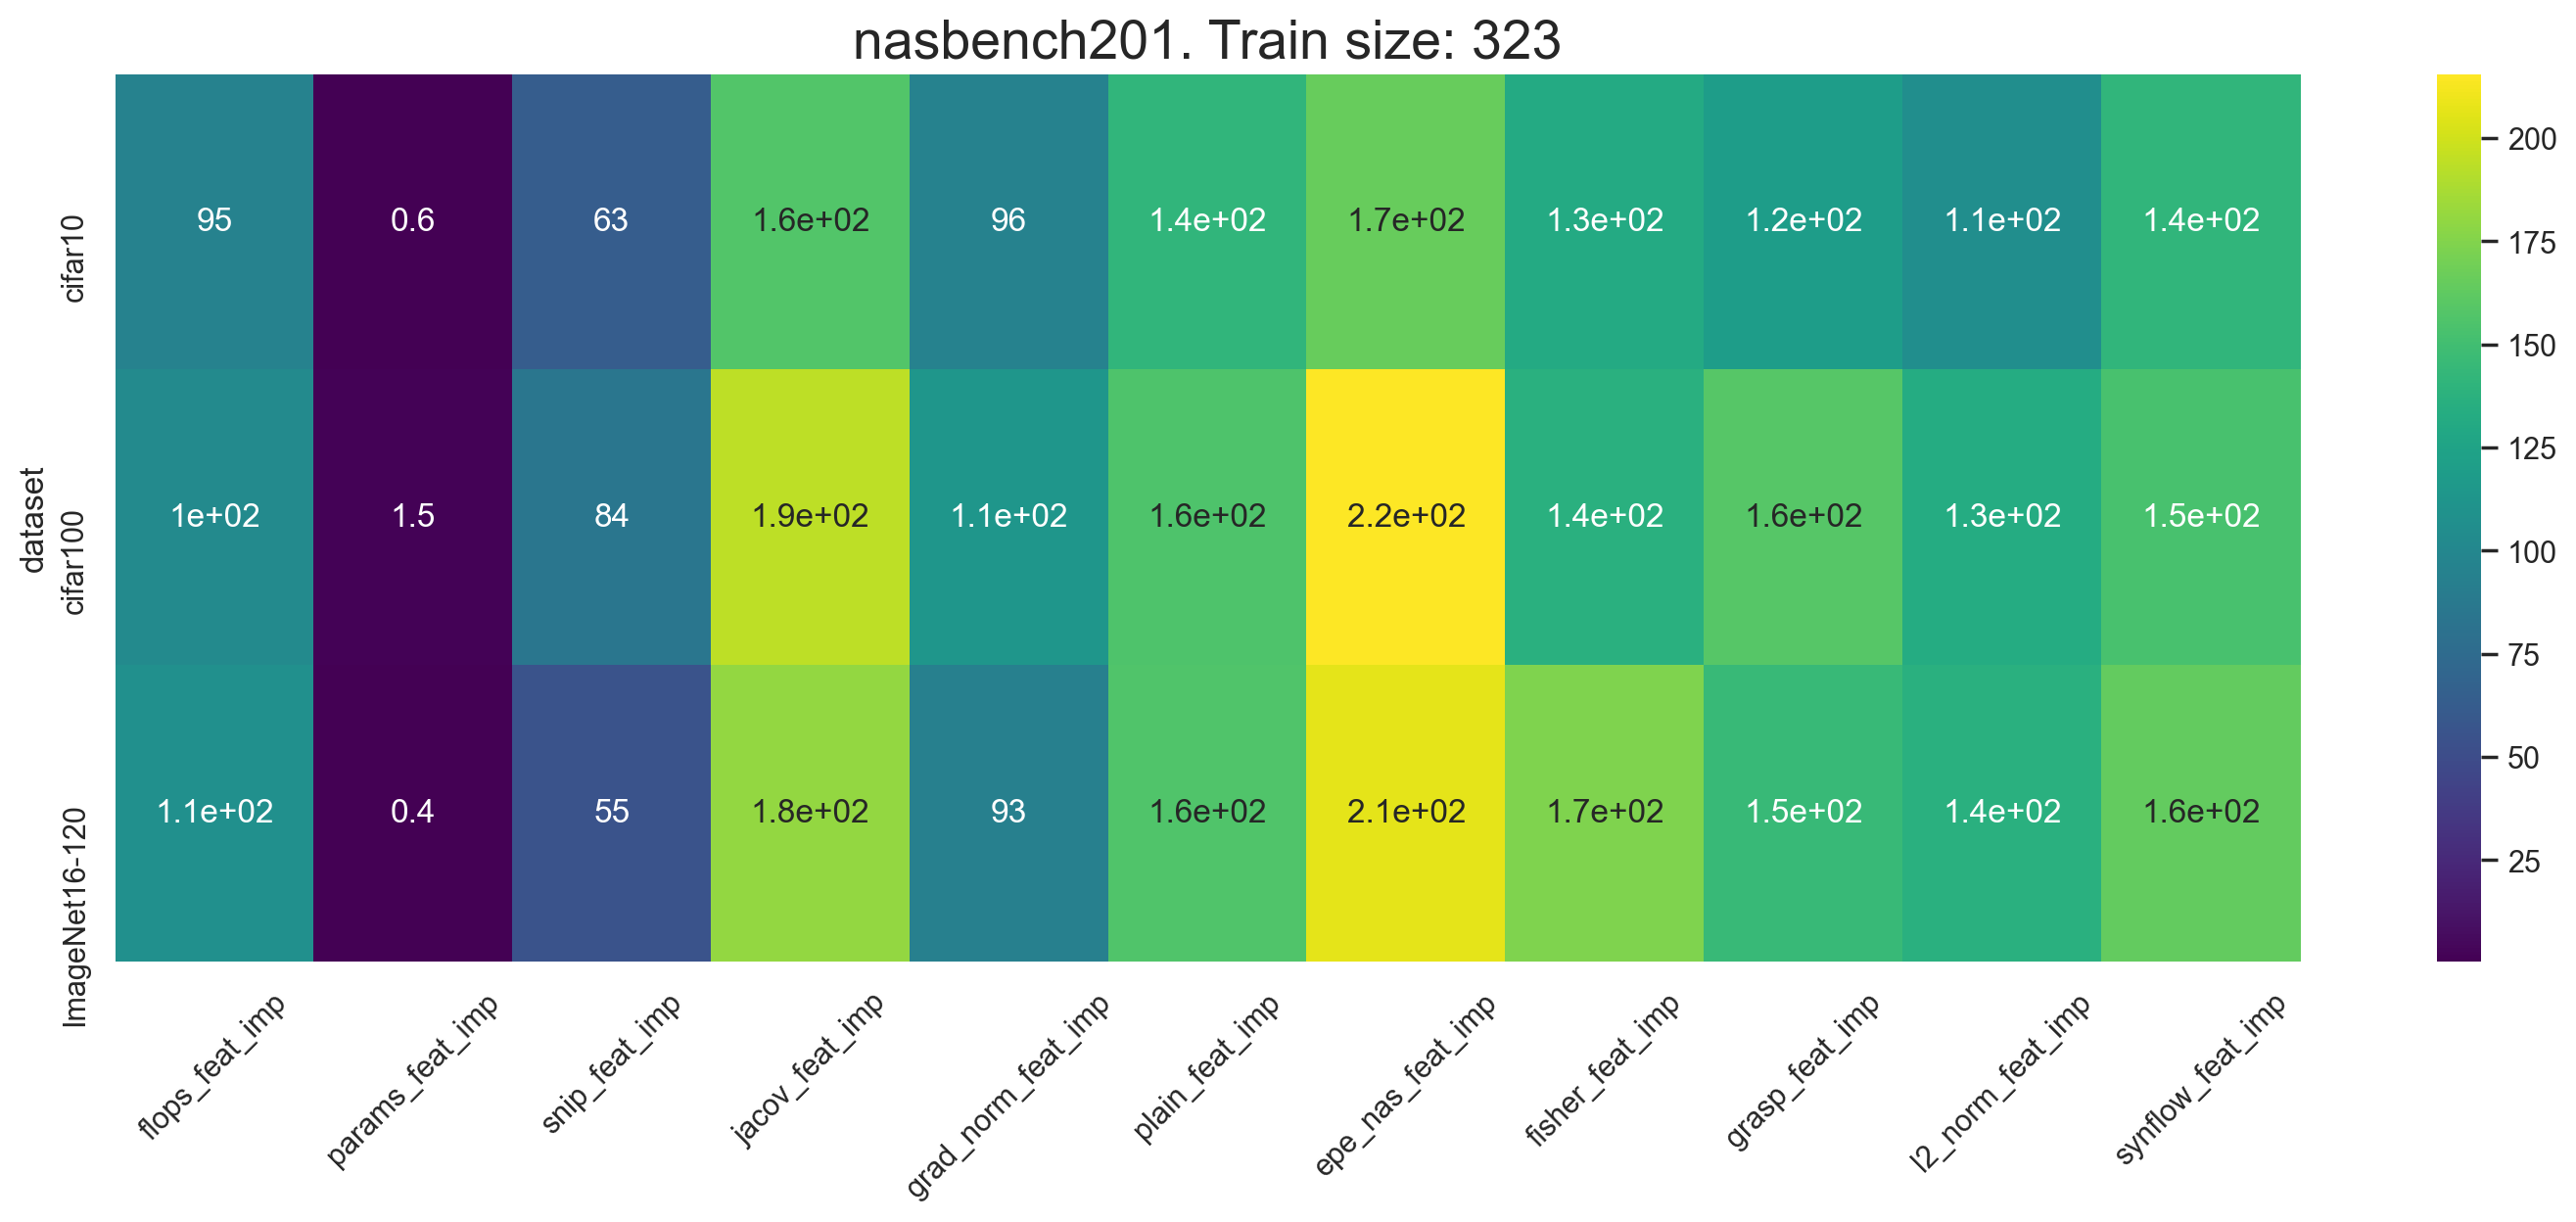

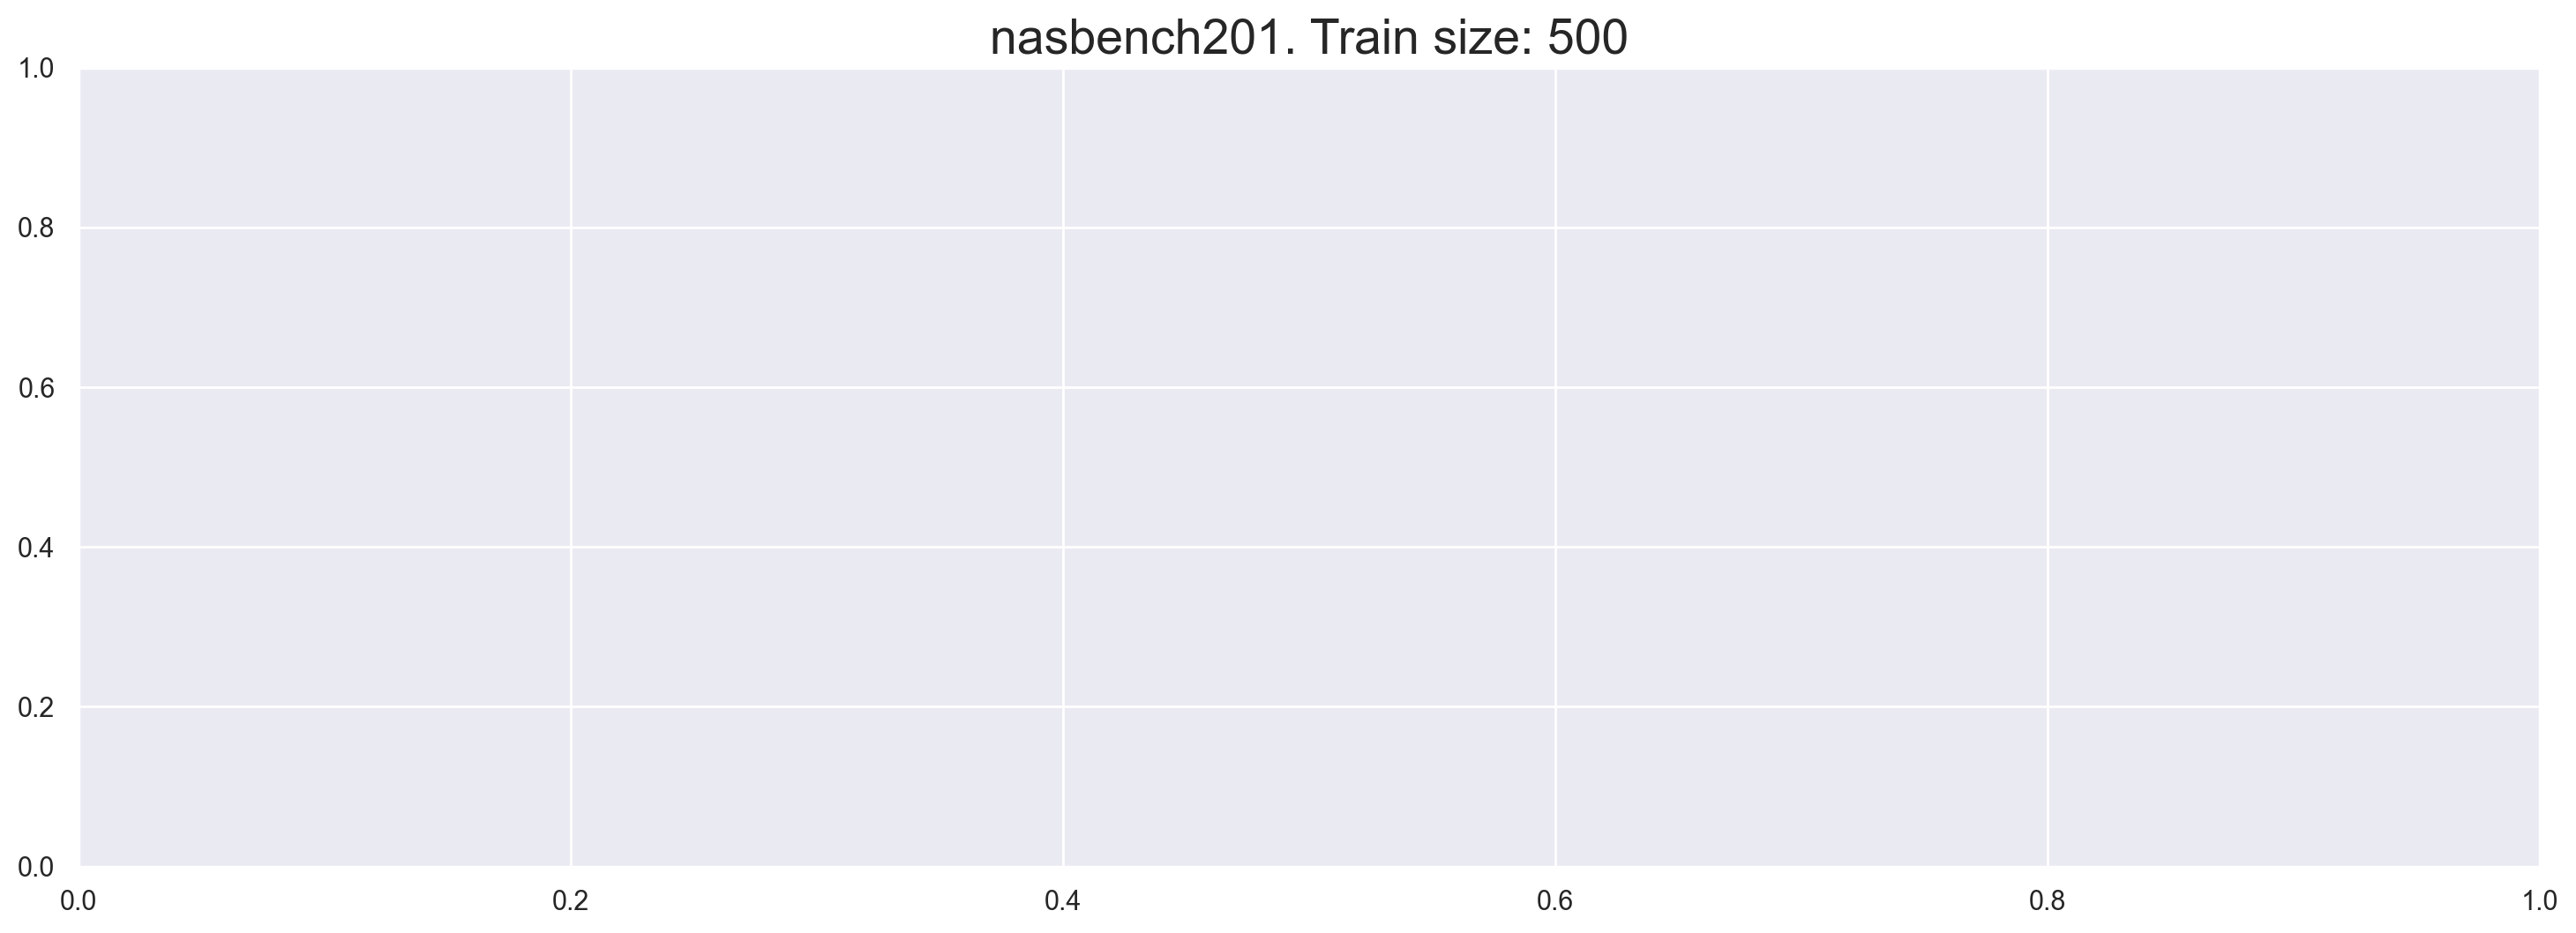

In [13]:
for train_size in train_sizes:
    plot_feature_importance_heatmap(df, 'nasbench201', train_size=train_size)


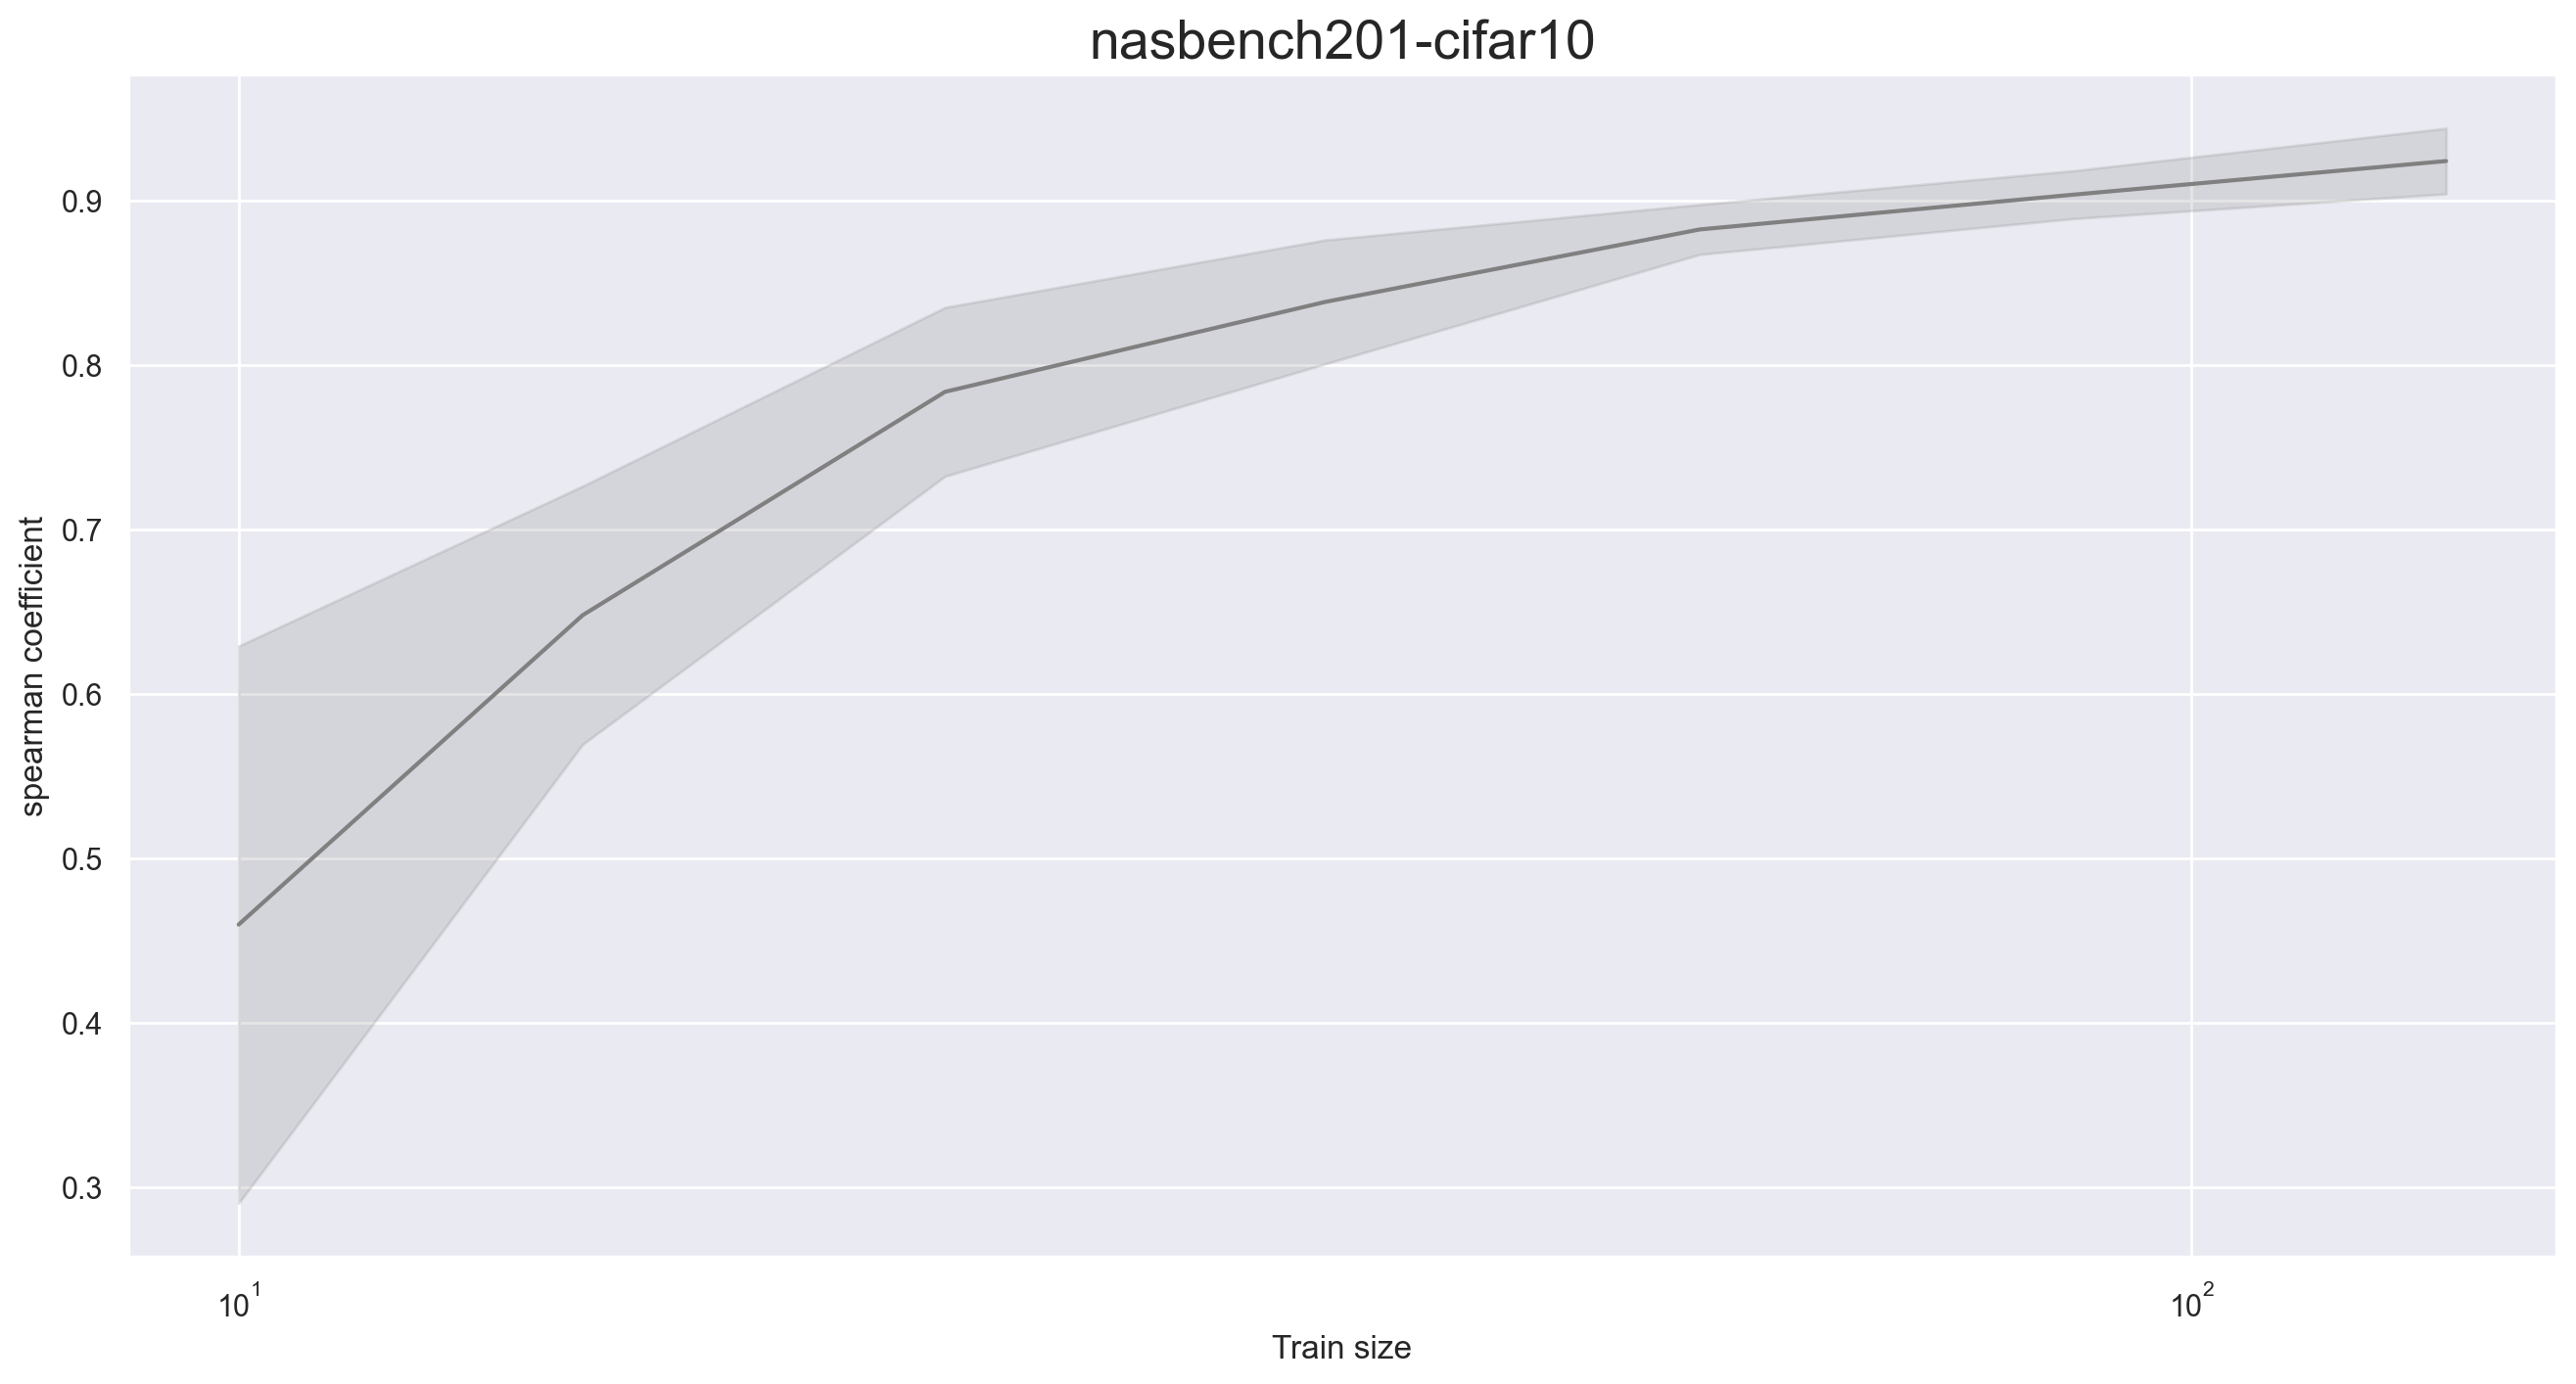

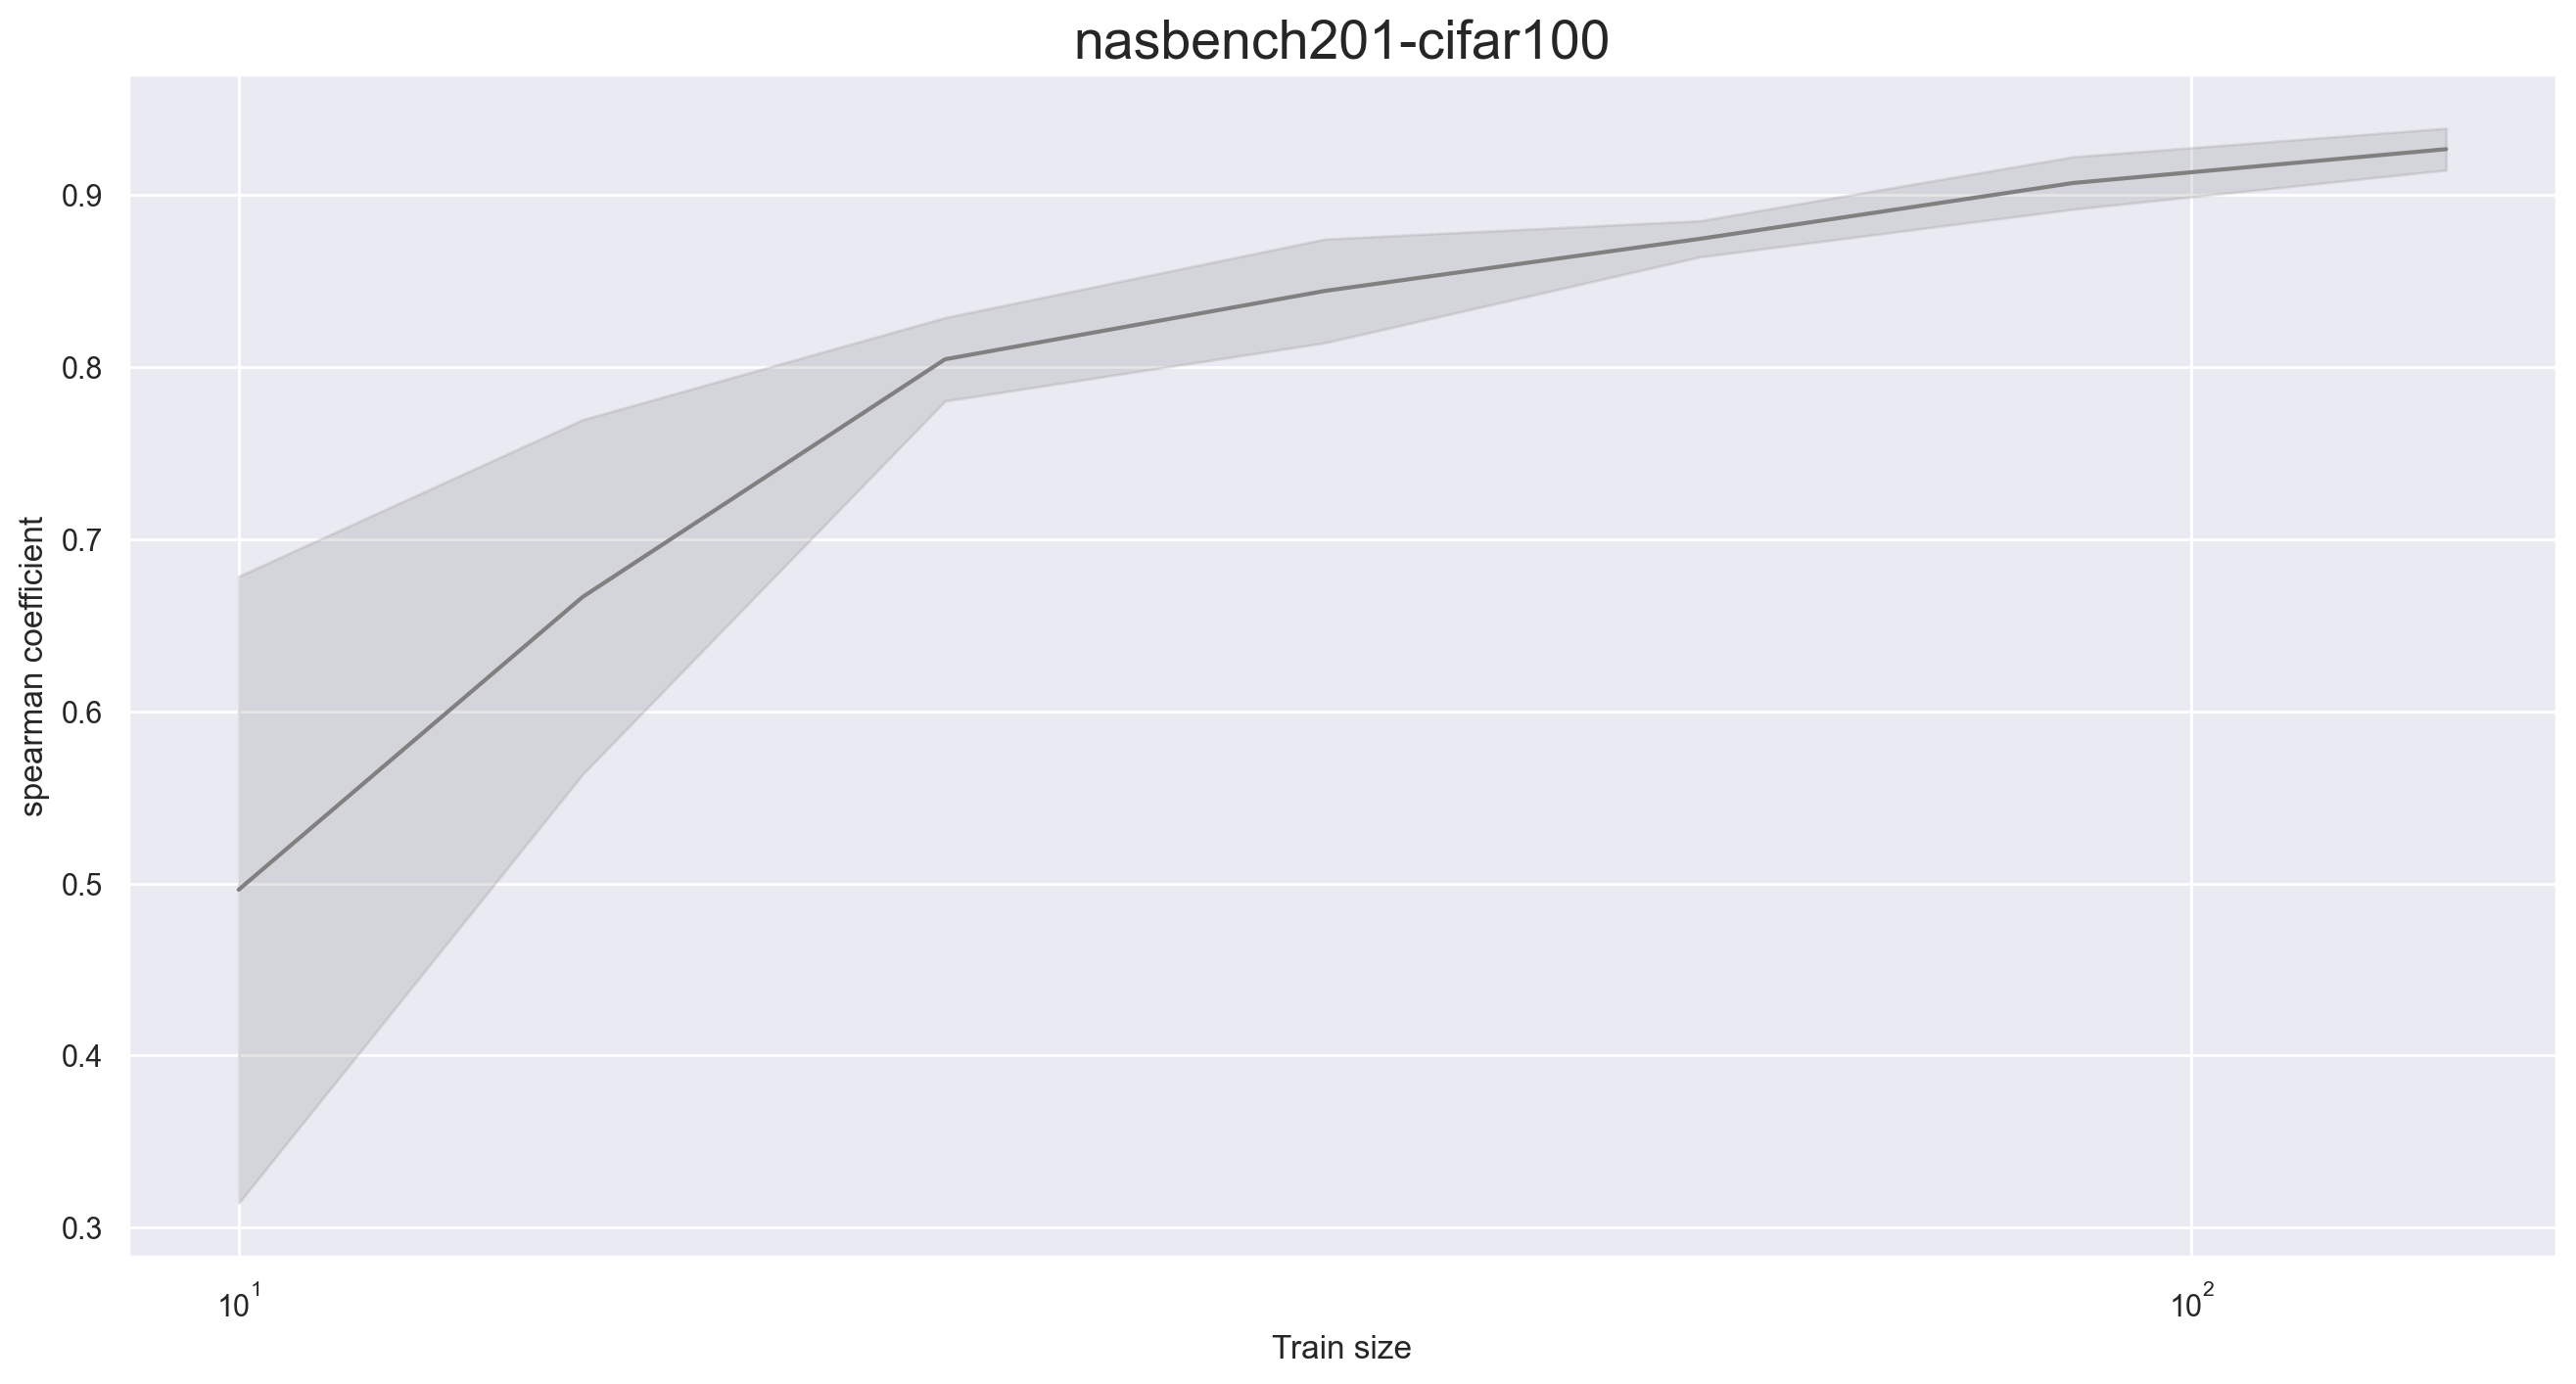

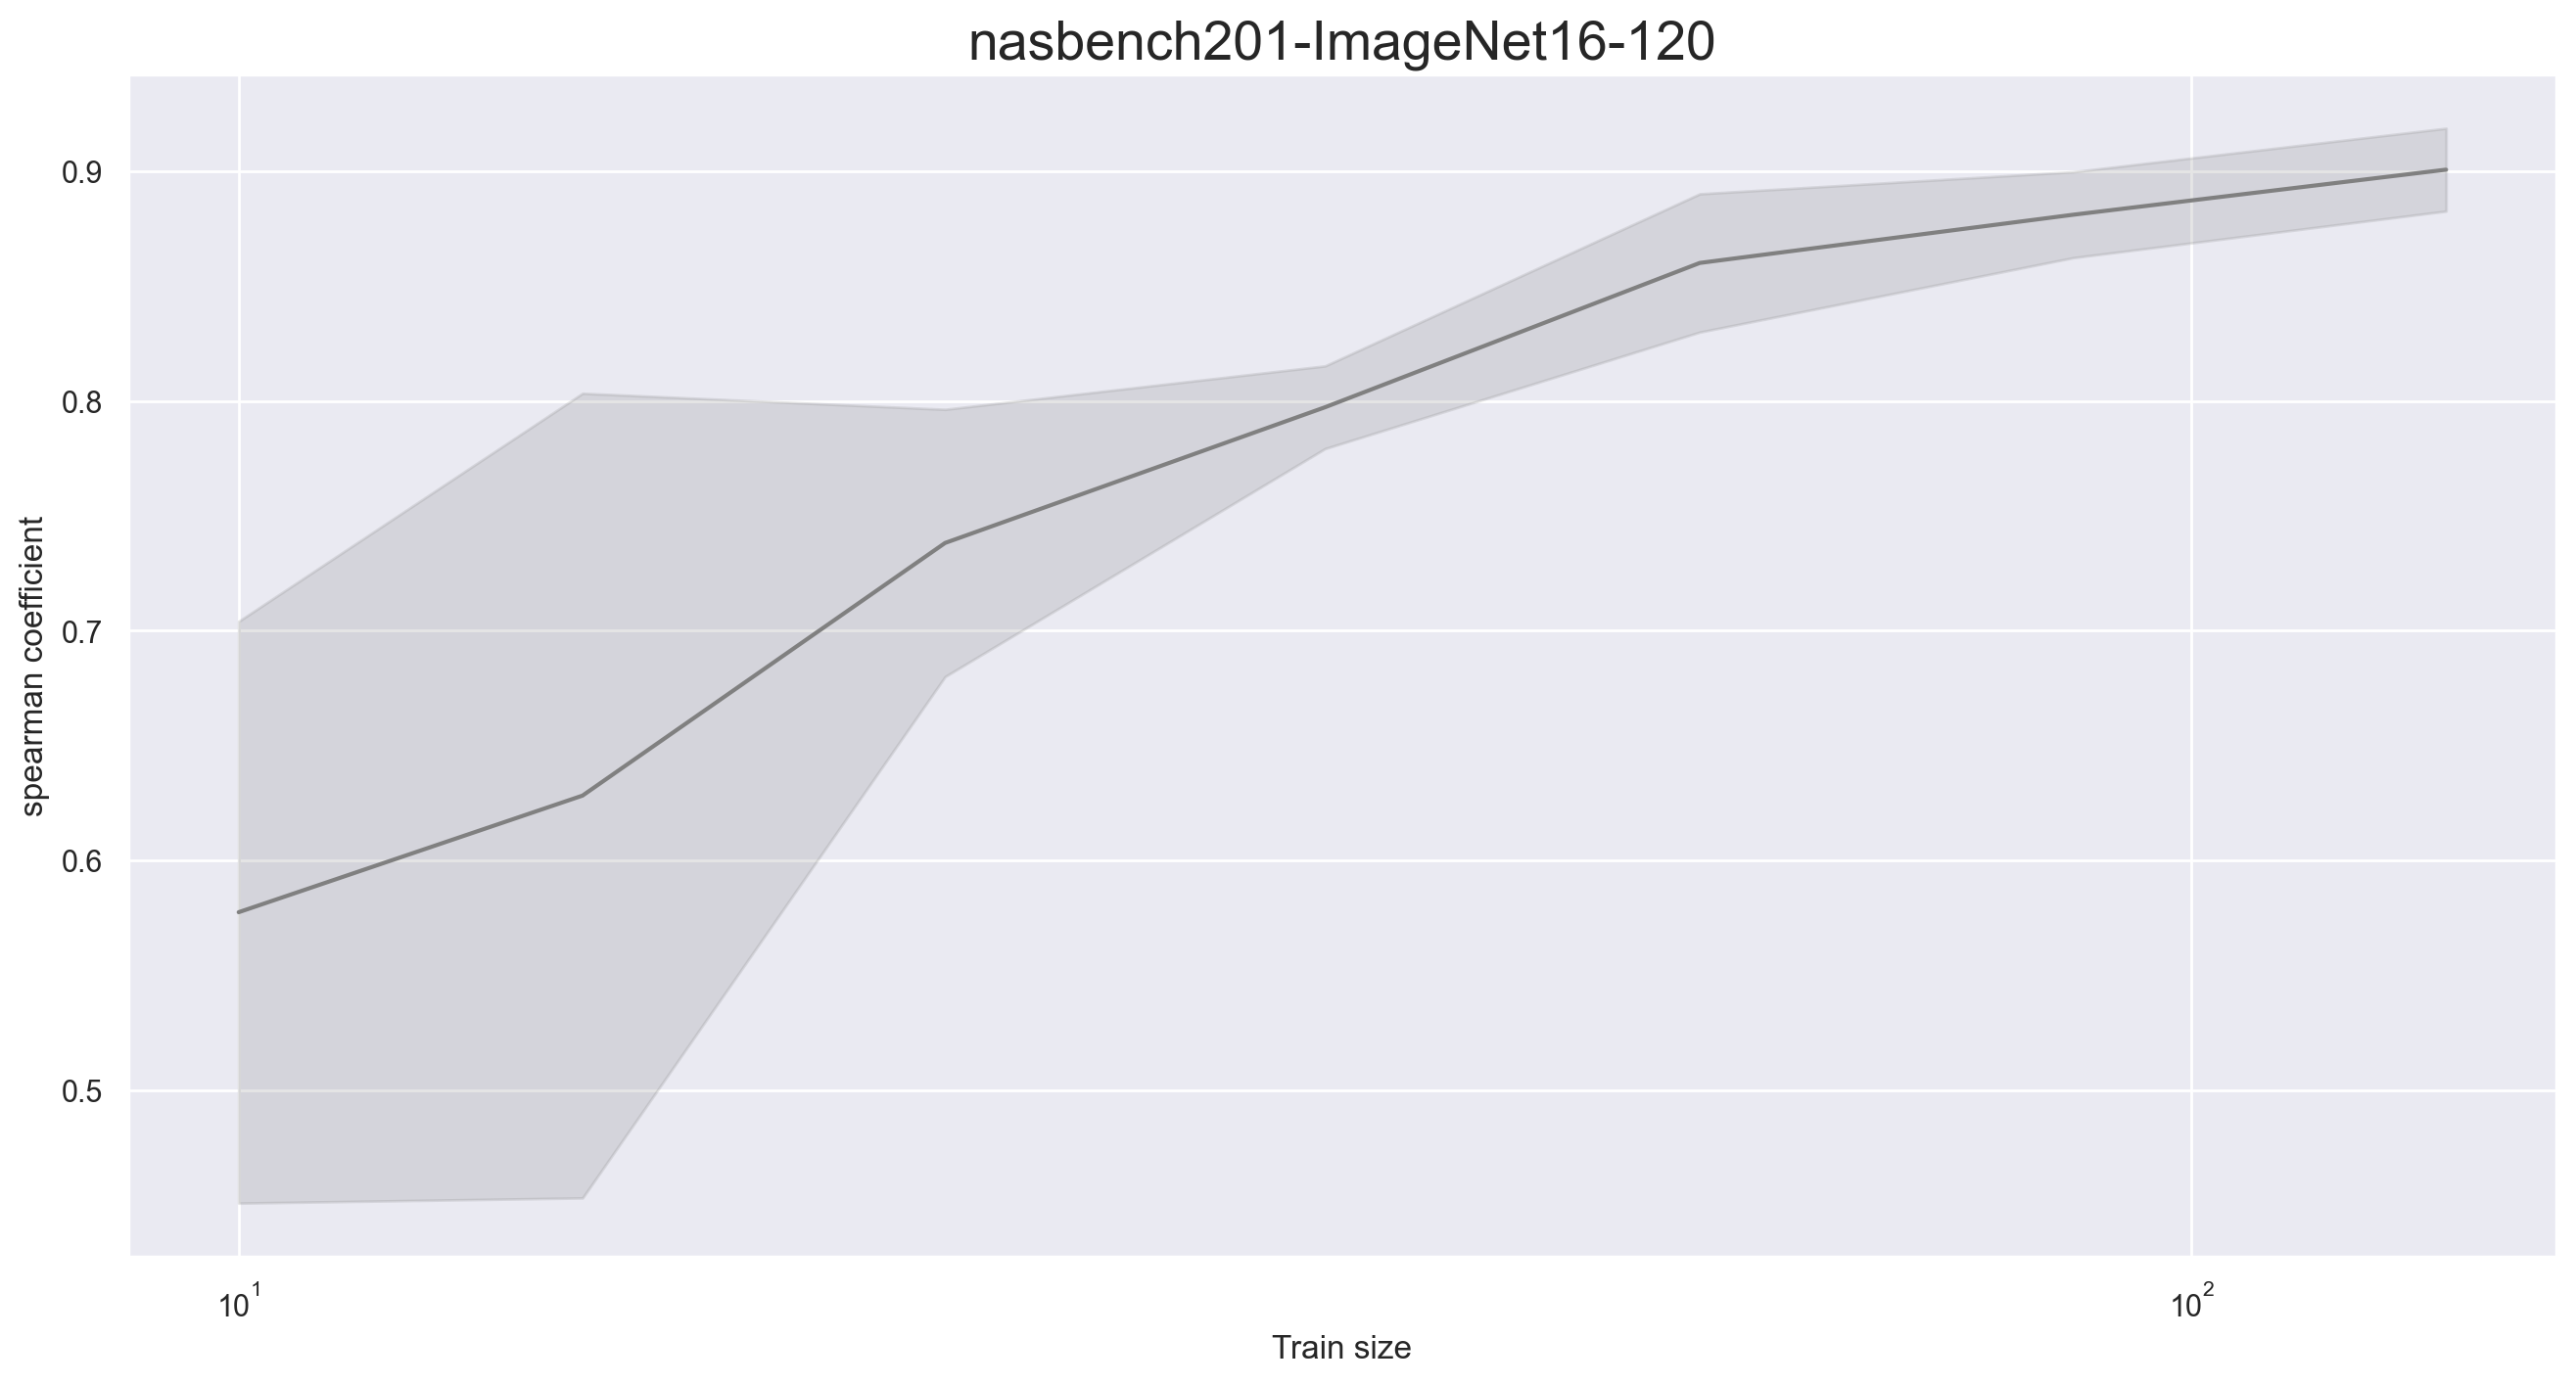

In [14]:
plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes[:7], 'spearman', color='grey')
plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes[:7], 'spearman', color='grey')
plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes[:7], 'spearman', color='grey')